# Data Analysis - Velib Project in [Python](https://www.python.org/) <a href="https://www.python.org/"><img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/community/logos/python-logo-only.png" style="max-width: 35px; display: inline" alt="Python"/></a>&nbsp;

---
Authors: Thanh-Chung NGUYEN, Hieu PHAM, Minh-Thi BUI and Dinh-Nam MAI

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

---



In [786]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score


In [648]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
OMP_NUM_THREADS=5

## Load data

In [649]:
path = 'data/'
loading = pd.read_csv(path+'velibLoading.csv', sep=" ")
loading


Lun-00    Lun-01    Lun-02    Lun-03    Lun-04    Lun-05    Lun-06  \
1     0.038462  0.038462  0.076923  0.038462  0.038462  0.038462  0.038462   
2     0.478261  0.478261  0.478261  0.434783  0.434783  0.434783  0.434783   
3     0.218182  0.145455  0.127273  0.109091  0.109091  0.109091  0.090909   
4     0.952381  0.952381  0.952381  0.952381  0.952381  0.952381  0.952381   
5     0.927536  0.811594  0.739130  0.724638  0.724638  0.724638  0.724638   
...        ...       ...       ...       ...       ...       ...       ...   
1185  0.000000  0.000000  0.000000  0.000000  0.000000  0.045455  0.000000   
1186  0.200000  0.133333  0.155556  0.177778  0.177778  0.177778  0.200000   
1187  0.551724  0.517241  0.551724  0.517241  0.517241  0.551724  0.551724   
1188  0.476190  0.428571  0.428571  0.428571  0.428571  0.428571  0.476190   
1189  0.937500  0.968750  0.906250  0.875000  0.906250  0.906250  0.937500   

        Lun-07    Lun-08    Lun-09  ...    Dim-14    Dim-15    Dim-16  \
1     0.038462  0.107143  0.000000  ...  0.296296  0.111111  0.111111   
2     0.434783  0.260870  0.043478  ...  0.043478  0.000000  0.217391   
3     0.090909  0.054545  0.109091  ...  0.259259  0.259259  0.203704   
4     1.000000  1.000000  1.000000  ...  1.000000  1.000000  0.904762   
5     0.724638  0.753623  0.971014  ...  0.227273  0.454545  0.590909   
...        ...       ...       ...  ...       ...       ...       ...   
1185  0.090909  0.136364  0.000000  ...  0.043478  0.173913  0.043478   
1186  0.177778  0.288889  0.511111  ...  0.266667  0.288889  0.155556   
1187  0.448276  0.241379  0.034483  ...  0.482759  0.310345  0.000000   
1188  0.523810  0.428571  0.476190  ...  0.880000  0.760000  0.750000   
1189  0.937500  0.968750  1.000000  ...  1.000000  1.000000  0.687500   

        Dim-17    Dim-18    Dim-19    Dim-20    Dim-21    Dim-22    Dim-23  
1     0.148148  0.307692  0.076923  0.115385  0.076923  0.153846  0.153846  
2     0.130435  0.045455  0.173913  0.173913  0.173913  0.260870  0.391304  
3     0.129630  0.148148  0.296296  0.314815  0.370370  0.370370  0.407407  
4     0.857143  0.857143  0.857143  0.761905  0.761905  0.761905  0.761905  
5     0.833333  1.000000  0.818182  0.636364  0.712121  0.621212  0.575758  
...        ...       ...       ...       ...       ...       ...       ...  
1185  0.086957  0.086957  0.304348  0.304348  0.130435  0.086957  0.086957  
1186  0.222222  0.333333  0.311111  0.355556  0.377778  0.333333  0.355556  
1187  0.000000  0.103448  0.379310  0.310345  0.310345  0.344828  0.482759  
1188  0.958333  1.000000  0.791667  0.791667  0.500000  0.434783  0.478261  
1189  0.550000  0.950000  0.444444  0.526316  0.894737  0.947368  0.833333  

[1189 rows x 168 columns]

The data are loading profiles of the bike stations over one week, collected every hour, from the period of Monday 2nd September to Sunday 7th September, 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks.
+ A loading of 1 means that the station is fully loaded, i.e. all bikes are available.
+ A loading of 0 means that the station is empty, i.e. all bikes have been rent.

In [650]:
loading.describe()


Lun-00       Lun-01       Lun-02       Lun-03       Lun-04  \
count  1189.000000  1189.000000  1189.000000  1189.000000  1189.000000   
mean      0.401503     0.408770     0.411718     0.415161     0.417136   
std       0.337079     0.335566     0.336132     0.337158     0.332237   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.093750     0.093023     0.096774     0.100000     0.108696   
50%       0.312500     0.333333     0.342857     0.350000     0.357143   
75%       0.694444     0.705882     0.708333     0.710526     0.700000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Lun-05       Lun-06       Lun-07       Lun-08       Lun-09  ...  \
count  1189.000000  1189.000000  1189.000000  1189.000000  1189.000000  ...   
mean      0.421650     0.419860     0.415729     0.384658     0.326331  ...   
std       0.326644     0.323422     0.319302     0.303621     0.314026  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.114286     0.114286     0.117647     0.114286     0.047619  ...   
50%       0.363636     0.360000     0.360000     0.320000     0.215385  ...   
75%       0.700000     0.700000     0.687500     0.636364     0.575000  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

            Dim-14       Dim-15       Dim-16       Dim-17       Dim-18  \
count  1189.000000  1189.000000  1189.000000  1189.000000  1189.000000   
mean      0.346147     0.325526     0.311334     0.306399     0.314730   
std       0.340516     0.339897     0.336863     0.331194     0.322904   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.051282     0.041667     0.038462     0.043478     0.052632   
50%       0.204082     0.166667     0.151515     0.142857     0.172414   
75%       0.651163     0.608696     0.555556     0.550000     0.550000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Dim-19       Dim-20       Dim-21       Dim-22       Dim-23  
count  1189.000000  1189.000000  1189.000000  1189.000000  1189.000000  
mean      0.334080     0.353493     0.385975     0.392552     0.397529  
std       0.317279     0.317572     0.328448     0.335061     0.341536  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.071429     0.080000     0.095238     0.086957     0.090909  
50%       0.200000     0.238095     0.285714     0.292683     0.292683  
75%       0.558140     0.600000     0.666667     0.666667     0.692308  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 168 columns]

Through the data summary table above, we can see that the number of bicycles available every hour at some stations is no longer available (min = 0), while some stations are still full of bicycles that are not rented (max = 1). This means that while some areas are experiencing high demand for bicycle rentals that cannot be met, many bicycles sitting at some stations are being wasted because they are not used at all.

**=> So we need to analyze the trend of using bicycles at stations and from there coordinate the number of bicycles to stations with high demand to meet the needs of people to optimize the use of bicycles in Paris.**

In [651]:
coord = pd.read_csv('data/velibCoord.csv', sep=" ")
coord

longitude   latitude  bonus                         names
1      2.377389  48.886300      0              EURYALE DEHAYNIN
2      2.317591  48.890020      0                     LEMERCIER
3      2.330447  48.850297      0               MEZIERES RENNES
4      2.271396  48.833734      0                        FARMAN
5      2.366897  48.845887      0              QUAI DE LA RAPEE
...         ...        ...    ...                           ...
1185   2.360216  48.884570      0          CHAPELLE MARX DORMOY
1186   2.316184  48.847770      0                         DUROC
1187   2.314630  48.811102      1   GEORGES MESSIER (MONTROUGE)
1188   2.439893  48.848258      0            VORGES (VINCENNES)
1189   2.331418  48.858943      0                 QUAI VOLTAIRE

[1189 rows x 4 columns]

In [652]:
print('missing data')
loading_missing_value = loading.isna().sum().sort_values(ascending=False) 
print('--- Loading ---')
print(loading_missing_value.sum())

coord_missing_value = coord.isna().sum().sort_values(ascending=False) 
print('--- coord ---')
print(coord_missing_value.sum())
print('---------------------------------')
print('duplicate data')
print('--- Loading ---')
print(loading.duplicated().sum())
print('--- Coord ---')
print(coord.duplicated().sum())

missing data
--- Loading ---
0
--- coord ---
0
---------------------------------
duplicate data
--- Loading ---
0
--- Coord ---
0


In the dataset, it does not contain missing data and duplicate data

In [653]:
data = pd.concat([coord, loading], axis=1)
data = data.rename(columns={data.columns[3]: 'Station'})


cols = data.columns.tolist()


cols.insert(0, cols.pop(cols.index('Station')))
data = data[cols]
start_index = 4  
end_index = 172  
new_column_names = {data.columns[i]: str(i - start_index + 1) for i in range(start_index, end_index)}


data = data.rename(columns=new_column_names)
data

Station  longitude   latitude  bonus         1  \
1                 EURYALE DEHAYNIN   2.377389  48.886300      0  0.038462   
2                        LEMERCIER   2.317591  48.890020      0  0.478261   
3                  MEZIERES RENNES   2.330447  48.850297      0  0.218182   
4                           FARMAN   2.271396  48.833734      0  0.952381   
5                 QUAI DE LA RAPEE   2.366897  48.845887      0  0.927536   
...                            ...        ...        ...    ...       ...   
1185          CHAPELLE MARX DORMOY   2.360216  48.884570      0  0.000000   
1186                         DUROC   2.316184  48.847770      0  0.200000   
1187   GEORGES MESSIER (MONTROUGE)   2.314630  48.811102      1  0.551724   
1188            VORGES (VINCENNES)   2.439893  48.848258      0  0.476190   
1189                 QUAI VOLTAIRE   2.331418  48.858943      0  0.937500   

             2         3         4         5         6  ...       159  \
1     0.038462  0.076923  0.038462  0.038462  0.038462  ...  0.296296   
2     0.478261  0.478261  0.434783  0.434783  0.434783  ...  0.043478   
3     0.145455  0.127273  0.109091  0.109091  0.109091  ...  0.259259   
4     0.952381  0.952381  0.952381  0.952381  0.952381  ...  1.000000   
5     0.811594  0.739130  0.724638  0.724638  0.724638  ...  0.227273   
...        ...       ...       ...       ...       ...  ...       ...   
1185  0.000000  0.000000  0.000000  0.000000  0.045455  ...  0.043478   
1186  0.133333  0.155556  0.177778  0.177778  0.177778  ...  0.266667   
1187  0.517241  0.551724  0.517241  0.517241  0.551724  ...  0.482759   
1188  0.428571  0.428571  0.428571  0.428571  0.428571  ...  0.880000   
1189  0.968750  0.906250  0.875000  0.906250  0.906250  ...  1.000000   

           160       161       162       163       164       165       166  \
1     0.111111  0.111111  0.148148  0.307692  0.076923  0.115385  0.076923   
2     0.000000  0.217391  0.130435  0.045455  0.173913  0.173913  0.173913   
3     0.259259  0.203704  0.129630  0.148148  0.296296  0.314815  0.370370   
4     1.000000  0.904762  0.857143  0.857143  0.857143  0.761905  0.761905   
5     0.454545  0.590909  0.833333  1.000000  0.818182  0.636364  0.712121   
...        ...       ...       ...       ...       ...       ...       ...   
1185  0.173913  0.043478  0.086957  0.086957  0.304348  0.304348  0.130435   
1186  0.288889  0.155556  0.222222  0.333333  0.311111  0.355556  0.377778   
1187  0.310345  0.000000  0.000000  0.103448  0.379310  0.310345  0.310345   
1188  0.760000  0.750000  0.958333  1.000000  0.791667  0.791667  0.500000   
1189  1.000000  0.687500  0.550000  0.950000  0.444444  0.526316  0.894737   

           167       168  
1     0.153846  0.153846  
2     0.260870  0.391304  
3     0.370370  0.407407  
4     0.761905  0.761905  
5     0.621212  0.575758  
...        ...       ...  
1185  0.086957  0.086957  
1186  0.333333  0.355556  
1187  0.344828  0.482759  
1188  0.434783  0.478261  
1189  0.947368  0.833333  

[1189 rows x 172 columns]

In [654]:
# Stations in descending order of occurrence
station_names = coord.names.value_counts().sort_values(ascending=False)
print(station_names)

# --- #
print('')

# We display the station with the most occurrences
name0 = station_names.index[0]
name1 = station_names.index[1] 
data[data.Station == name0 ]



 PORTE DES LILAS           3
 GARE D'AUSTERLITZ         3
 GARE DE L'EST             2
 AQUEDUC                   2
 DODU                      2
                          ..
 CHARONNE                  1
 BOUSSINGAULT - TOLBIAC    1
 RIVOLI MAIRIE DU 1ER      1
 JOURDAN BARBOUX           1
 QUAI VOLTAIRE             1
Name: names, Length: 1161, dtype: int64



Station  longitude   latitude  bonus    1    2    3    4  \
362   PORTE DES LILAS   2.404770  48.876604      1  0.0  0.0  0.0  0.0   
450   PORTE DES LILAS   2.405960  48.875412      1  0.0  0.0  0.0  0.0   
957   PORTE DES LILAS   2.411046  48.878099      1  0.0  0.0  0.0  0.0   

            5         6  ...  159  160  161   162  163  164  165       166  \
362  0.689655  0.655172  ...  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.034483   
450  0.000000  0.500000  ...  0.0  0.0  0.0  0.05  0.0  0.0  0.0  0.000000   
957  0.000000  0.000000  ...  0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.000000   

     167   168  
362  0.0  0.00  
450  0.0  0.05  
957  0.0  0.00  

[3 rows x 172 columns]

In [655]:
data[data.Station == name1 ]


Station  longitude   latitude  bonus         1         2  \
81    GARE D'AUSTERLITZ   2.364045  48.842524      0  0.928571  0.642857   
676   GARE D'AUSTERLITZ   2.365586  48.843790      0  0.296296  0.296296   
702   GARE D'AUSTERLITZ   2.366124  48.840577      0  0.090909  0.054545   

            3         4         5         6  ...       159  160       161  \
81   0.142857  0.142857  0.142857  0.142857  ...  1.000000  1.0  1.000000   
676  0.037037  0.037037  0.037037  0.037037  ...  0.961538  1.0  0.962963   
702  0.054545  0.054545  0.054545  0.036364  ...  1.000000  1.0  0.703704   

          162       163       164       165       166       167       168  
81   0.928571  0.428571  0.214286  0.214286  0.428571  0.307692  0.071429  
676  0.629630  0.814815  0.148148  0.592593  0.555556  0.555556  0.074074  
702  0.811321  0.735849  0.462963  0.240741  0.092593  0.037037  0.018519  

[3 rows x 172 columns]

Here we notice that some stations close together have the same name, for example the names PORTE DES LILAS and GARE D'AUSTERTZ are taken for 3 stations.

## An Overview of the Dataset to Its Properties

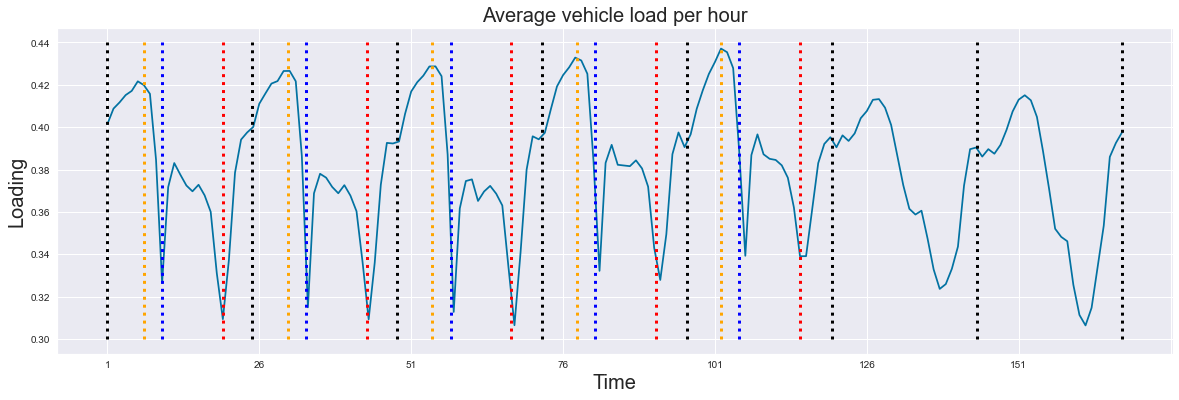

In [656]:
# Line chart for average
time_tick  = np.linspace(0, 167, 8)  # beginning of days
time_tick1  = np.linspace(0, 95, 5)  # beginning of days

plt.figure(figsize  = (20,6))

data.iloc[:, 4:].mean().plot(kind='line')
plt.vlines(x = time_tick, ymin = 0.3, ymax = 0.44, 
           colors = "black", linestyle = "dotted", linewidth = 3)
plt.vlines(x = time_tick1+6, ymin = 0.3, ymax = 0.44, 
           colors = "orange", linestyle = "dotted", linewidth = 3)
plt.vlines(x = time_tick1+9, ymin = 0.3, ymax = 0.44, 
           colors = "blue", linestyle = "dotted", linewidth = 3)
plt.vlines(x = time_tick1+19, ymin = 0.3, ymax = 0.44, 
           colors = "red", linestyle = "dotted", linewidth = 3)
plt.title('Average vehicle load per hour', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.show()


##### <span style="color:orange"> + The vertical orange line corresponds to the **7 AM** mark each day. </span>
##### <span style="color:blue"> +  The vertical blue line corresponds to the **10 AM** mark each day. </span>
##### <span style="color:red"> +  The vertical red line corresponds to the **8 PM** mark each day. </span>


#### For weekdays,

The chart indicates that from 7 AM to 10 AM, the number of bikes per station decreases rapidly as people need them for commuting and other purposes. After this period, people gradually return bikes until midday, then begin renting them again, resulting in an average decrease in the remaining bikes until 8 PM. After this time until 7 AM the next day, people gradually return bikes. This suggests that from 10 AM to 8 PM, there is high demand for bike rentals among the public.

#### For weekends,

There is a continuous demand for bike rentals from morning to evening, suggesting either sustained rental activity throughout the day or high demand during this period leading to continuous bike rentals. Since people don't have to work on weekends, there's no midday return surge like on weekdays. From evening to morning the next day, bikes are gradually returned to the stations as well.

#### Comparing weekdays to weekends, the overall trend of bicycle usage is quite similar. However, there are some differences:

1. **Midday Return Surge**: On weekdays, there's a noticeable surge in bike returns at stations around midday, which is absent on weekends. This indicates that on weekdays, people tend to return bikes during their lunch breaks or midday activities, while on weekends, this pattern is not observed.

2. **Peak Averages**: The peak averages on weekends are consistently lower than those on weekdays. This can be attributed to the habit of continuous bike rentals on weekends, as opposed to the need to return bikes early in the morning to return home or to work, as seen on weekdays. 

Overall, while the general trends in bike usage are similar, these differences highlight distinct patterns in behavior between weekdays and weekends, particularly in terms of bike return habits and peak usage times. 

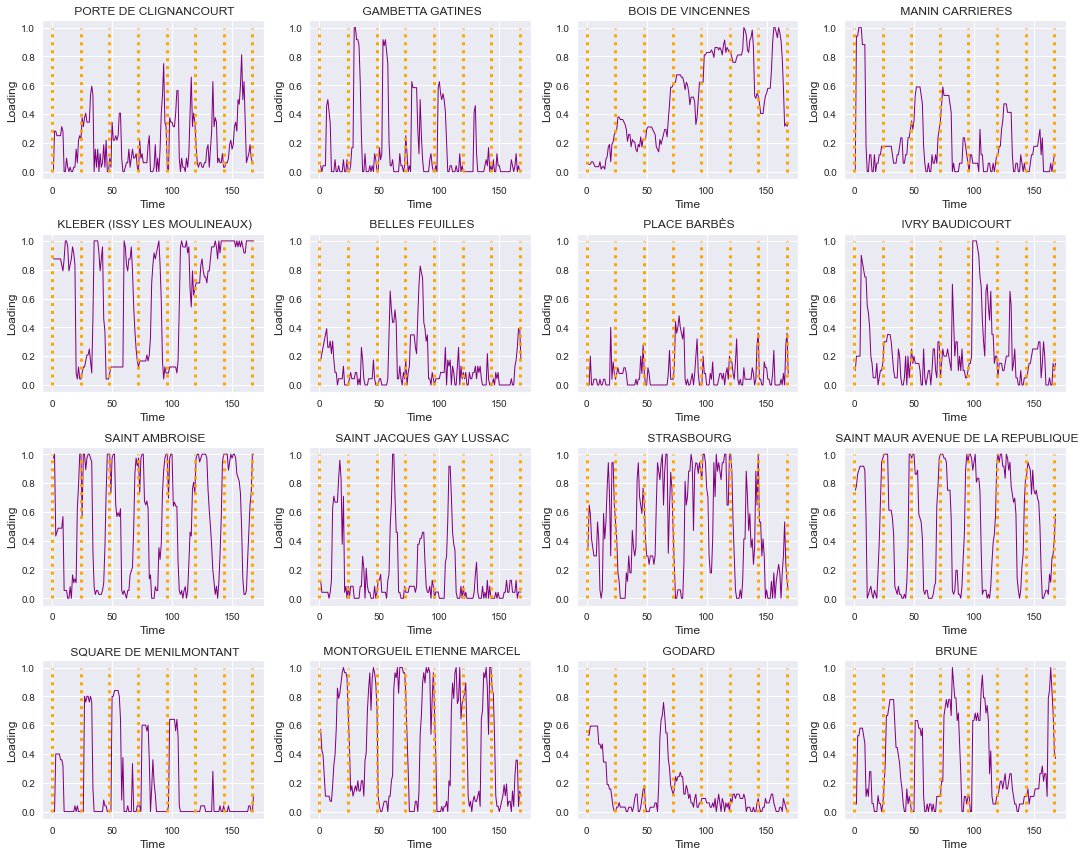

In [657]:

# We select 16 stations at random
stations = np.arange(loading.shape[0])
rd.shuffle(stations)
stations = stations[:16] 
time_range = np.linspace(1, 168, 168)  # observed time range
loading_data = loading.to_numpy()

# --- #

fig, axs = plt.subplots(4, 4, figsize = (15,12))

for i in range(4):
    for j in range(4):
        k_station = stations[4 * i + j]
        axs[i, j].plot(time_range, loading_data[k_station, :], linewidth = 1, color = 'purple')
        axs[i, j].vlines(x = time_tick, ymin = 0, ymax = 1, colors = "orange", linestyle = "dotted", linewidth = 3)
        axs[i, j].set_title(coord.names[1 + k_station], fontsize = 12)

for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
plt.tight_layout()
plt.show()

The chart displays bike loadings at 16 randomly selected stations. It's evident that each station exhibits unique variations. Some stations consistently maintain low bike levels almost all the time, while others consistently have a high availability of bikes. Additionally, there are stations where bike availability fluctuates significantly over time, for instance, consistently high during the daytime and consistently low during nighttime.

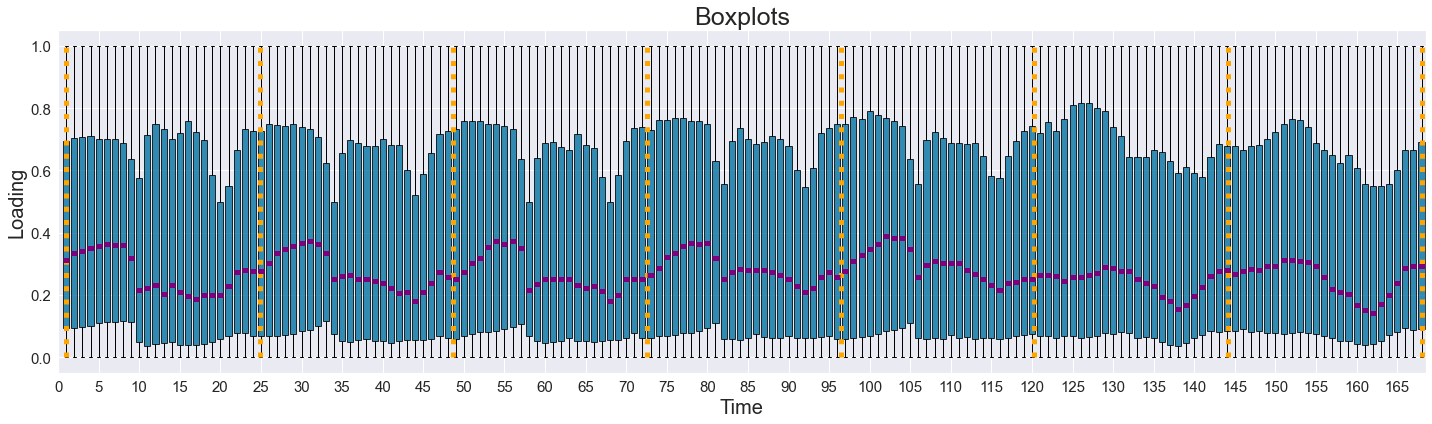

In [658]:
loading_data = loading.to_numpy()
n_steps    = loading.shape[1]
time_tick  = np.linspace(1, n_steps, 8)
plt.figure(figsize = (20,6))
bp = plt.boxplot(loading_data, widths = 0.75, patch_artist = True)

for box in bp['boxes']:
    box.set_alpha(0.8)  
    
for median in bp['medians']:
    median.set(color = "Purple", linewidth=5)
    
plt.vlines(x = time_tick, ymin = 0, ymax = 1, 
           colors = "Orange", linestyle = "dotted", linewidth = 5)

plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.title("Boxplots", fontsize = 25)

plt.xticks(ticks = np.arange(0, 168, 5), labels=np.arange(0, 168, 5), fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show()

In addition to the points analyzed from the average line chart above, we can make some additional observations from the boxplot graph as follows:

#### 1. Dynamics throughout the day
+ For weekdays, the early morning hours (midnight to 7 AM) show little variation in bike loadings between hours, suggesting minimal bike rentals and returns during this period. However, during midday and evening hours, there are significant fluctuations at certain peak stations, indicating high and consistent demand for bike usage.

+ On weekends, fluctuations are observed throughout the day, except for 6 and 7 AM.

#### 2. Amplitude of each column

Every hour, there are always stations running out of bikes and stations with full capacity. Therefore, it's necessary to redistribute the bike supply among these stations to avoid wasting bikes at underutilized stations during each time frame and simultaneously meet the high demand for bike rentals at peak stations.


Also the column usually ranges from very close to 0.05 to about 0.8, indicating that at any given time there are stations that are nearly empty but also many stations with many bicycles available. This means that most stations still meet people's car rental needs.


## Chargement moyen

--- Average fill rate ---
0.3816217759807477

--- Least crowded station, on average ---
 HORNET (BAGNOLET)
0.016132842025699153

--- Fullest station, on average ---
 INSURRECTION AOUT 1944 (IVRY)
0.9193722943722953


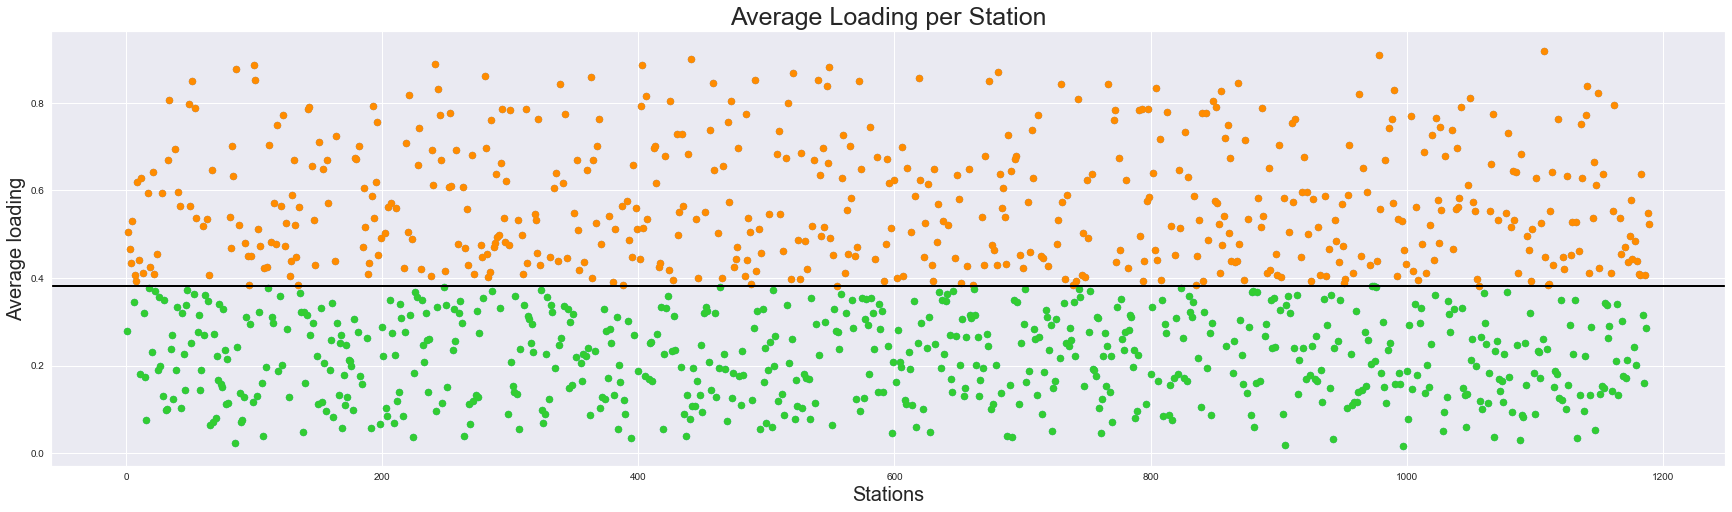


--- Number of stations above the average ---
549

--- Number of stations below the average ---
640


In [659]:
average_fill_rate = loading.mean().mean()
print('--- Average fill rate ---')
print(average_fill_rate)


least_crowded_station = loading.mean(axis=1).idxmin() 
print('\n--- Least crowded station, on average ---')
print(coord.iloc[least_crowded_station-1,3])
print(loading.mean(axis=1)[least_crowded_station])


fullest_station = loading.mean(axis=1).idxmax()  
print('\n--- Fullest station, on average ---')
print(coord.iloc[fullest_station-1,3])
print(loading.mean(axis=1)[fullest_station])


df = pd.DataFrame({
    'stations': np.arange(1, len(loading) + 1),  
    'mean': loading.mean(axis=1) 
})

above_average_count = 0
below_average_count = 0

plt.figure(figsize  = (30,8))
plt.scatter(df['stations'], df['mean'], color='cornflowerblue', s=50)  

for index, row in df.iterrows():
    if row['mean'] > average_fill_rate:
        plt.scatter(row['stations'], row['mean'], color='darkorange', s=50)
        above_average_count += 1
    else:
        plt.scatter(row['stations'], row['mean'], color='limegreen', s=50)
        below_average_count += 1

plt.axhline(y=average_fill_rate, color='black', linewidth=2)  
plt.xlabel('Stations',fontsize = 20)
plt.ylabel('Average loading',fontsize = 20)
plt.title('Average Loading per Station',fontsize = 25)
plt.show()

print('\n--- Number of stations above the average ---')
print(above_average_count)

print('\n--- Number of stations below the average ---')
print(below_average_count)




From the "Average fill rate" value, we can see that the average remaining bike supply at stations over one week is only about 1/3, which is a relatively low figure. These bike stations efficiently meet the demand for bike usage by the public, as they use a considerable number of bikes for transportation. Therefore, the goal of modification may be to lower this value, implying that bike stations are more frequently utilized, which would indicate improved efficiency.

In particular, some stations like HORNET have a very low average load rate of 0.016 (almost close to 0), indicating that bikes at this station are continuously rented, which may lead to a shortage of bikes there. Therefore, it's essential to regularly replenish bikes at such stations from less utilized stations to meet the high demand there. For example, at the INSURRECTION AOUT 1944 station, the average load rate is 0.91 (almost always full), so we can consider relocating a certain number of bikes from stations like this to high-demand stations like HORNET. However, we need to consider whether the high demand for bike rentals occurs simultaneously between these stations to avoid a situation where bikes are taken from stations with low bike availability to those with similarly low availability, resulting in insufficient bikes for rent at the original station.

From the above chart, we also observe that the number of stations with a higher than average average load rate does not significantly differ from the number of stations with a lower than average average load rate. However, there are quite a few stations that consistently have a relatively high average load rate (> 80%), while there are many stations with a relatively low average load rate (<20%). Therefore, it's necessary to redistribute the bike supply between these two types of stations to avoid bike wastage at low-demand stations and utilize them to meet the high demand at stations with high rental demands.


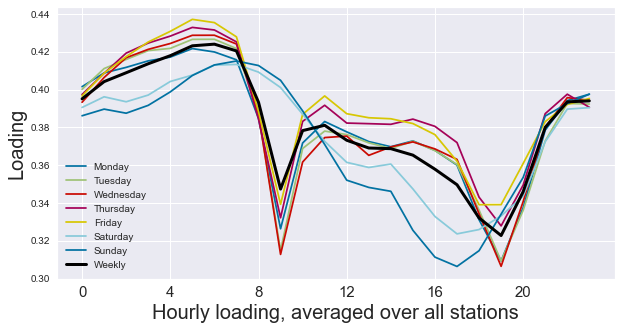

In [660]:
loading_mean = pd.Series(loading.mean(axis=1))
mean_per_hour_per_day = loading.mean(axis = 0).to_numpy()
mean_per_hour_per_day = mean_per_hour_per_day.reshape((7, 24))

mean_per_hour = mean_per_hour_per_day.mean(axis=0)

# --- #

days = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize = (10,5))

plt.plot(mean_per_hour_per_day.transpose())
plt.plot(mean_per_hour, color = "black", linewidth = 3)

plt.xlabel('Hourly loading, averaged over all stations', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.legend(days + ['Weekly'])
plt.xticks(ticks = np.arange(0,24,4), labels=np.arange(0,24,4), fontsize = 15)
  
plt.tight_layout
plt.show()

Overall, there is a similarity in the changes in the average load rate of all bike stations between weekdays, but it differs from weekends. For weekdays, the graph descends earlier, indicating that the demand for bike rentals by the public starts earlier in the weekdays compared to weekends. Meanwhile, during midday and early afternoon hours, when people are at work or school, there is an increase in bike returns, resulting in an increase in bike availability at stations. Conversely, during weekends, bikes are typically rented from morning to evening as people engage in recreational activities or errands.


#### For weekdays:



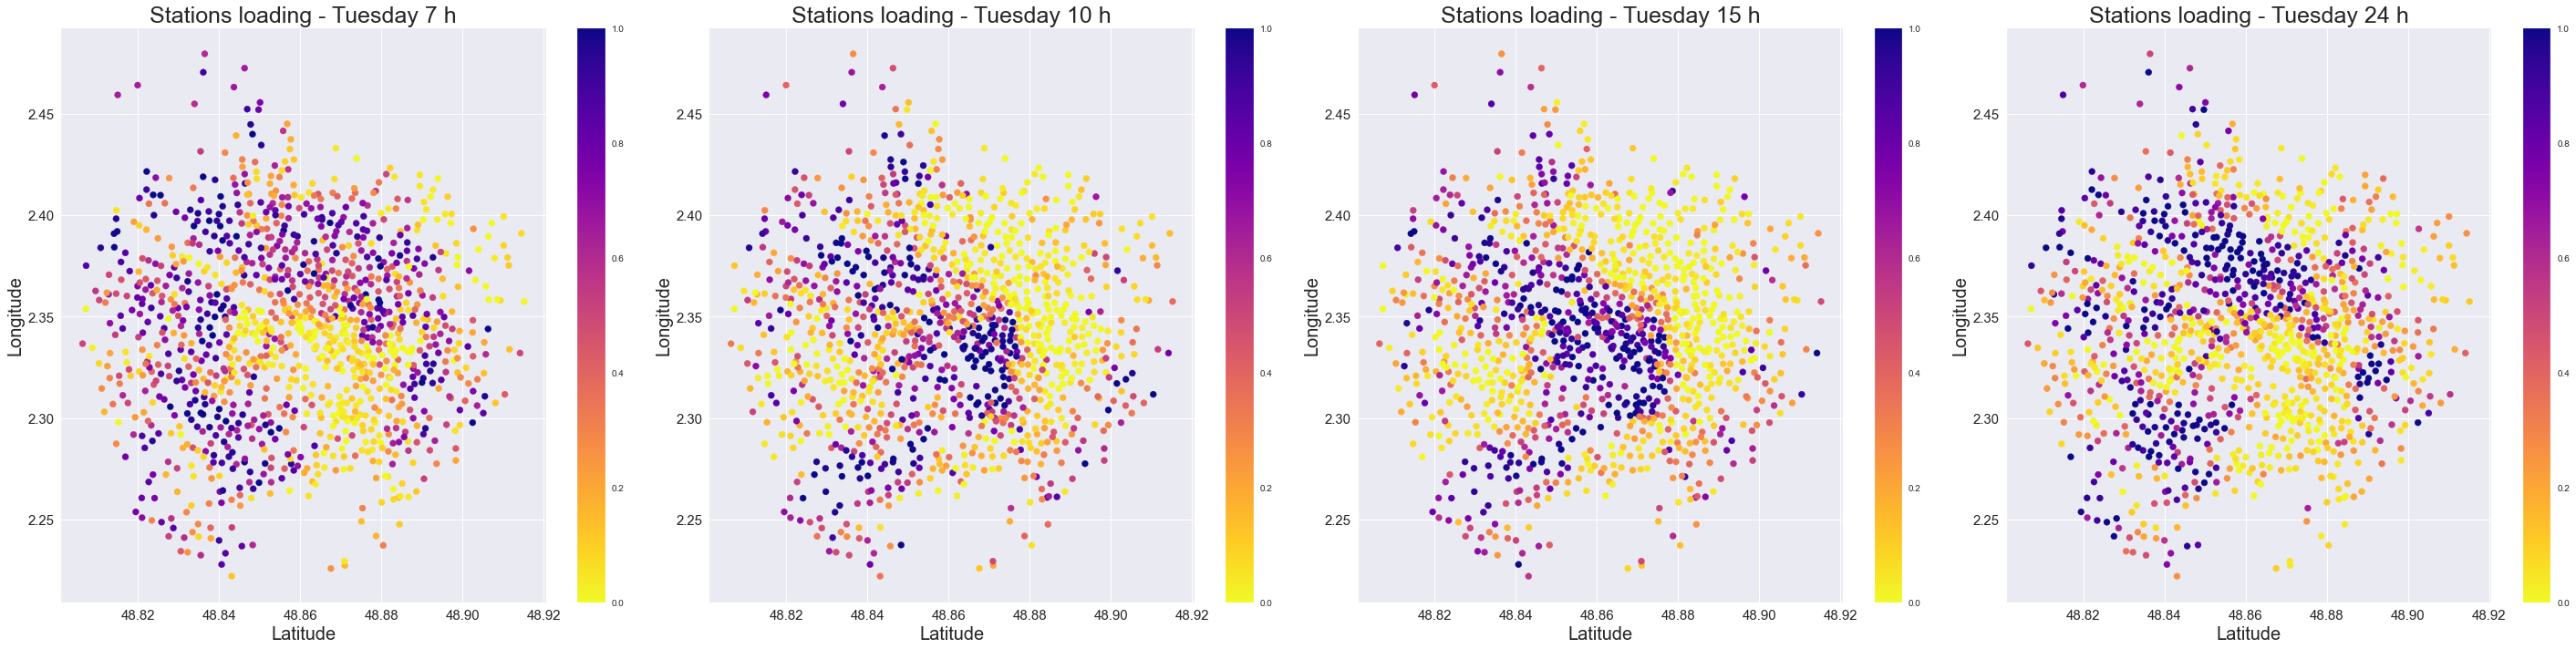

In [661]:
hours = [31,34,39,48]

# --- #

s, n = 10, len(hours)
fig, axs = plt.subplots(1, n, figsize = (s*n, s))

for (i,h) in enumerate(hours):
    im = axs[i].scatter(coord.latitude, coord.longitude, c = loading_data[:,h], cmap = cm.plasma_r)
    axs[i].set_title('Stations loading - Tuesday {} h'.format(h-24), fontsize = 25)
    plt.colorbar(im, ax=axs[i])
        
for ax in axs.flat:
    ax.set_xlabel('Latitude', fontsize = 20)
    ax.set_ylabel('Longitude', fontsize = 20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

Because the weekdays tend to exhibit similar patterns of change, we can use Thursday as a representative day for analysis. It can be observed that from morning to evening, the average bike load rate at suburban stations remains low, while the average load rate at central stations remains high. This implies that on weekdays, people have a significant demand for using bikes to commute from suburban areas to the city center for work or study purposes.

#### For weekends:


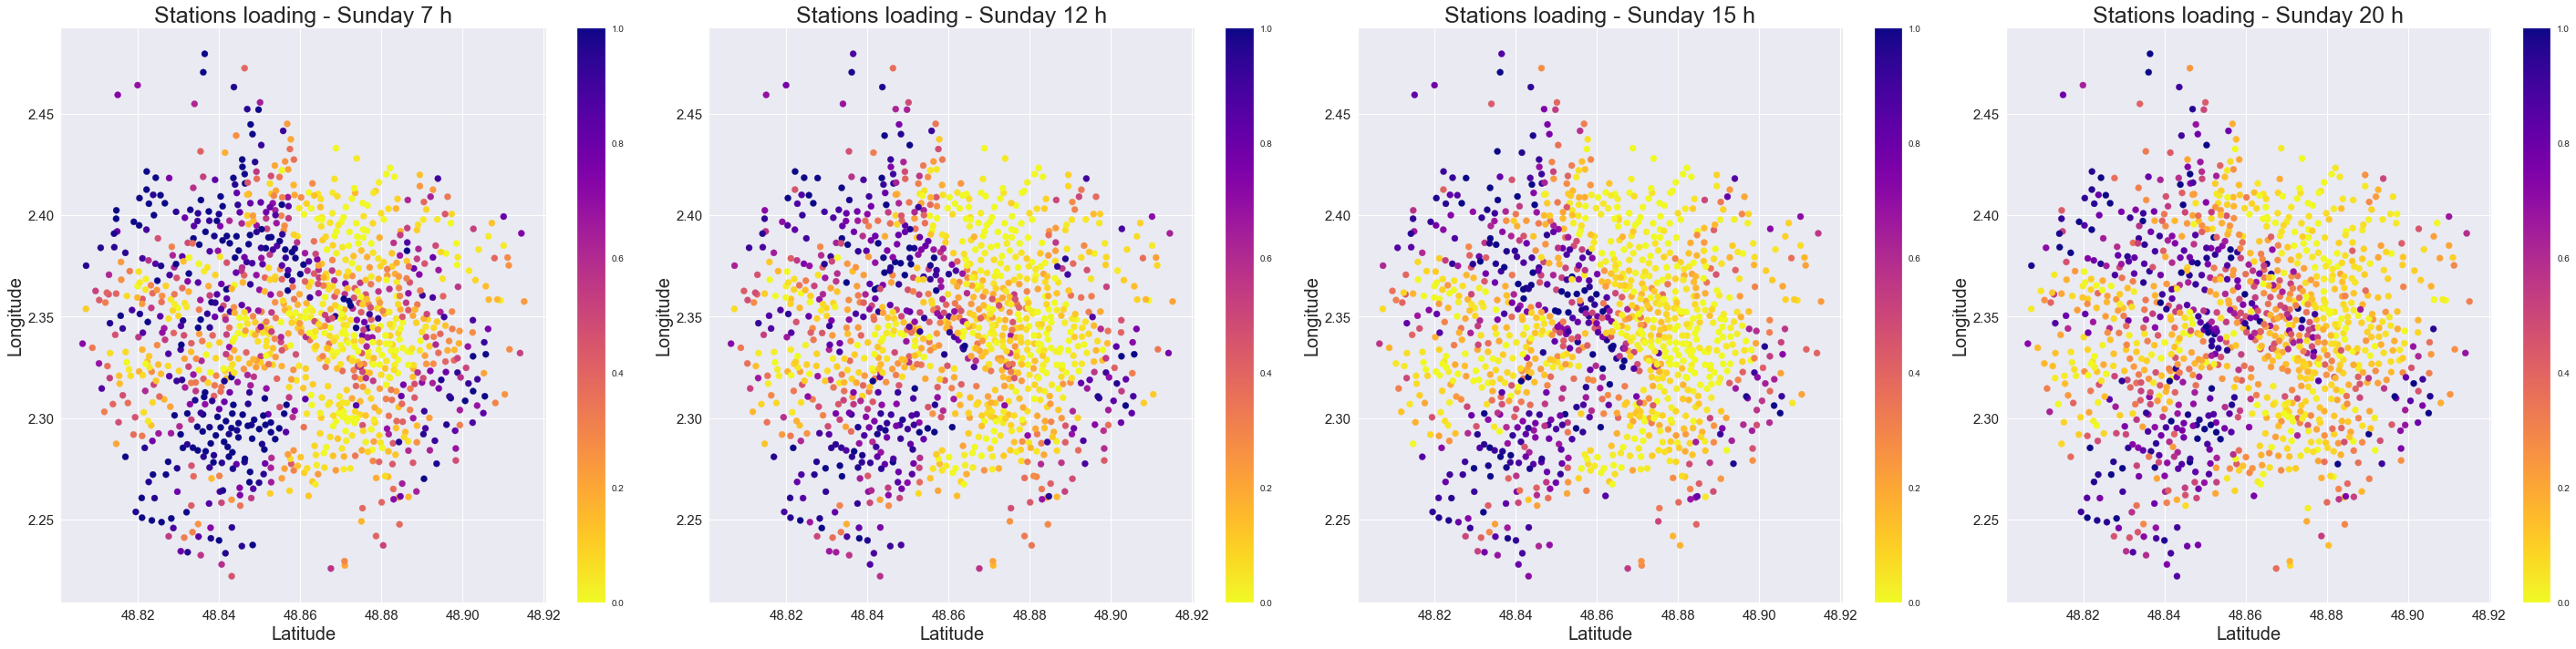

In [662]:
hours = [151,156,159,164]

# --- #

s, n = 10, len(hours)
fig, axs = plt.subplots(1, n, figsize = (s*n, s))

for (i,h) in enumerate(hours):
    im = axs[i].scatter(coord.latitude, coord.longitude, c = loading_data[:,h], cmap = cm.plasma_r)
    axs[i].set_title('Stations loading - Sunday {} h'.format(h-24*6), fontsize = 25)
    plt.colorbar(im, ax=axs[i])
        
for ax in axs.flat:
    ax.set_xlabel('Latitude', fontsize = 20)
    ax.set_ylabel('Longitude', fontsize = 20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()

Here we can observe that on weekends, there is a similar trend to weekdays, indicating a high demand for using bikes to commute from suburban areas to the city center.

## Dimension reduction by Principal Component Analysis (PCA)

In [743]:
data_scale = data.copy()
ss = StandardScaler()
data_scale.iloc[:, 4:] = ss.fit_transform(data.iloc[:, 4:])
pca = PCA()
pca_result = pca.fit_transform(data_scale.iloc[:, 4:])


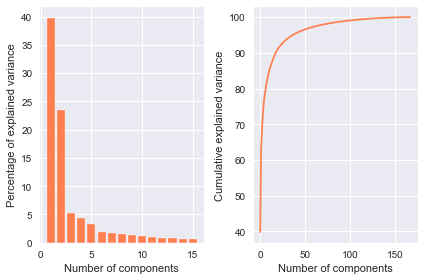

Variance explained by the first 2 components: 63.32


In [745]:
explained_variance_ratio = 100*pca.explained_variance_ratio_

plt.subplot(1,2,1)
n_bars = 15
x = np.arange(1, n_bars + 1)
plt.bar(x, explained_variance_ratio[:n_bars], color='coral')
plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance")

plt.subplot(1,2,2)

plt.plot(np.cumsum(explained_variance_ratio), color='coral')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

plt.tight_layout()
plt.show()
print("Variance explained by the first 2 components:", round(sum([explained_variance_ratio[i] for i in range(2)]),2))

**Left Graph (Percentage of Explained Variance):**
 This graph shows the percentage of variation explained by each principal component. The first component accounts for the highest percentage of variation, with about 40%, which suggests it contains the majority of information.
Subsequent components have decreasing importance, with increasingly lower percentages of explained variation.
Through the first two components, it can be seen that they explain a significant portion of the variation in the data.

**Graph on the right (Cumulative Explained Variance):**
 This plot shows the cumulative sum of the variance explained when adding each principal component.
Clearly, we can see that the first five components explained almost 76% of the total variation in the data. This shows that this number of components can be used to effectively summarize most of the information contained in the original data, while removing noise and reducing dimensionality.

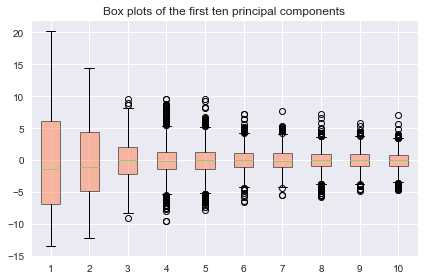

In [665]:
box = plt.boxplot(pca_result[:,:10], patch_artist=True)
plt.setp(box["boxes"], facecolor="coral", alpha=.5)
plt.title("Box plots of the first ten principal components")
plt.tight_layout()
plt.show()

The boxplot graph illustrates the distribution of scores of the principal components from PCA for the first ten principal components of the standardized dataset.

### Boxplot Analysis of the First Ten Principal Components

**Overview**: Each boxplot represents the distribution of scores of the corresponding principal component from the standardized dataset. These scores represent how each observation is represented in the space of the corresponding principal component.

#### General Observations:
1. **Variability**: The first principal component has a larger range of variability compared to the subsequent components, indicating that it contains a significant amount of variance information in the data.
2. **Median and Outliers**:
   - The **median** of each boxplot typically lies near or at 0, indicating proper centering of the data during normalization.
   - **Outliers** are depicted by individual points outside the "whiskers" of the boxplots, indicating these observations have significantly high or low scores in the principal component compared to the rest of the data.

#### Component-wise Analysis:
- **Components 1 and 2**: Exhibit considerable variability ranging from approximately -13 to 20. This large dispersion indicates their significant role in explaining variation in the data.
- **Components 3 to 10**: These components have narrower and relatively stable ranges, with "whiskers" not extending beyond -10 and 10. The medians close to 0 indicate symmetric distributions around the central point.

### Conclusion:
- **Utility of the First Component**: Given its ability to explain a large amount of variation in the data, the first component warrants further consideration.
- **Dimensionality Reduction**: Based on the cumulative explained variance plot analyzed earlier, you may consider using only a small number of the first components for subsequent analyses, particularly if they explain sufficient variance.

This graph provides valuable insights into the distribution and importance of components post PCA application, aiding in evaluating the effectiveness of data dimensionality reduction before conducting deeper analyses or building predictive models.

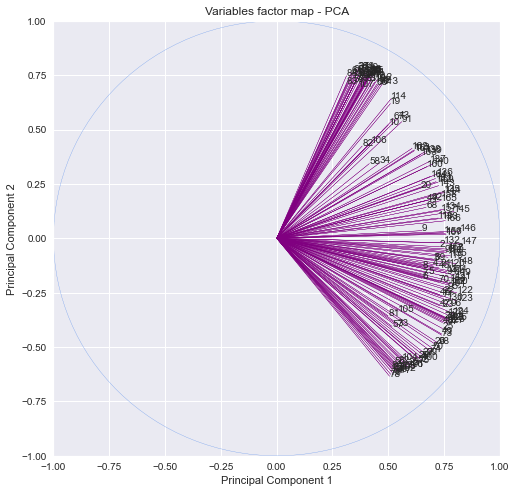

In [666]:
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord2, data_scale.iloc[:, 4:].columns):
    plt.text(i, j, nom, fontsize=10)
    plt.arrow(0, 0, i, j, color = 'purple', width = 0.0001)

plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius = 1, color = 'cornflowerblue', fill = False))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Variables factor map - PCA')
plt.show()

- **Variable Influence**: Variables with long arrows pointing far from the origin (0,0) have a significant influence on the corresponding principal component. For example, variables 9 and 14 have high loadings on the first component. If the arrows extend far from the center, it indicates that the variable is crucial in explaining the variation captured by that principal component.

- **Correlation between Variables**: Two variables with arrows pointing in nearly the same direction indicate a positive correlation (approximating a correlation close to 1). If they are perpendicular to each other, they have no correlation (approximating a correlation close to 0). For instance, if variables 19 and 81 are perpendicular, it means they are uncorrelated.

- **Loadings on Components**: Variables with arrows primarily pointing horizontally (or vertically) contribute predominantly to the corresponding principal component. Variables with arrows pointing vertically have high loadings on the second component.

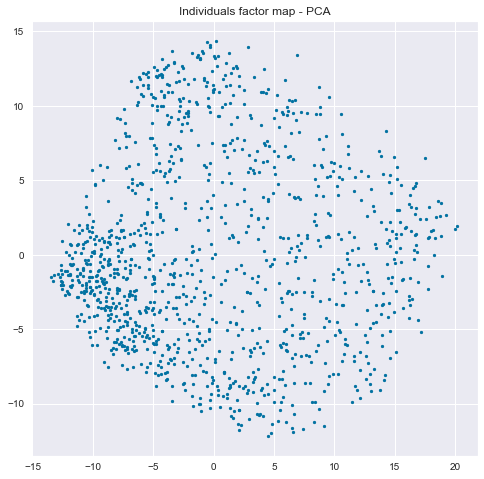

In [667]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=5, linewidths=1)
plt.title("Individuals factor map - PCA")
plt.show()

**Data concentration:** The data is distributed around the origin (0,0)

**Biaxial dispersion:** The data tends to be more scattered along the X axis than the Y axis, which suggests that the first principal component is more influential in explaining variation in the data than the first principal component. second main ingredient.

**Extremes:** There are some points far from the origin, especially along the X axis, indicating that these observations have very high or very low values for the first principal component. These observations can be considered outliers or have very special characteristics compared to the rest of the data.

### Meaning:

**Value of components:** Observations with high values on the first or second principal component indicate which characteristics are important in distinguishing the observations. The first principal component may represent a set of variables that are highly correlated with each other, while the second principal component represents a different set.

**Distribution of the data:** The concentrated distribution and how far apart the points are can help identify groups in the data or general trends that are not apparent when looking at individual variables.

In [668]:
def biPlot(scores, coords, labels=None):
    '''
    Inputs:
        scores: coordinates of the projected data
        coord: coordinates of the features, i.e. eigenvectors (PCs)
        labels: the class labels
    '''    
    xs = scores[:,0] # projection on PC1
    ys = scores[:,1] # projection on PC2
    n = coords.shape[0] # number of variables
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.figure(figsize=(10,8), dpi=100)
    plt.scatter(xs * scalex, ys * scaley, c = labels, s = 5, alpha = .3)
    
    for i in range(n):
        # plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coords[i,0], coords[i,1], color = 'k', alpha = 1, linestyle = '-', linewidth = 2, overhang=0.2)
        if labels is None:
            plt.text(coords[i,0]* 1.15, coords[i,1] * 1.15, "Var"+str(i+1), color = 'seagreen', ha = 'center', va = 'center')
        else:
            plt.text(coords[i,0]* 1.15, coords[i,1] * 1.15, labels[i], color = 'seagreen', ha = 'center', va = 'center')

    plt.xlim(-0.5,0.8)
    plt.ylim(-0.5,0.6)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.tick_params(axis='both', which='both')  #labelsize=14

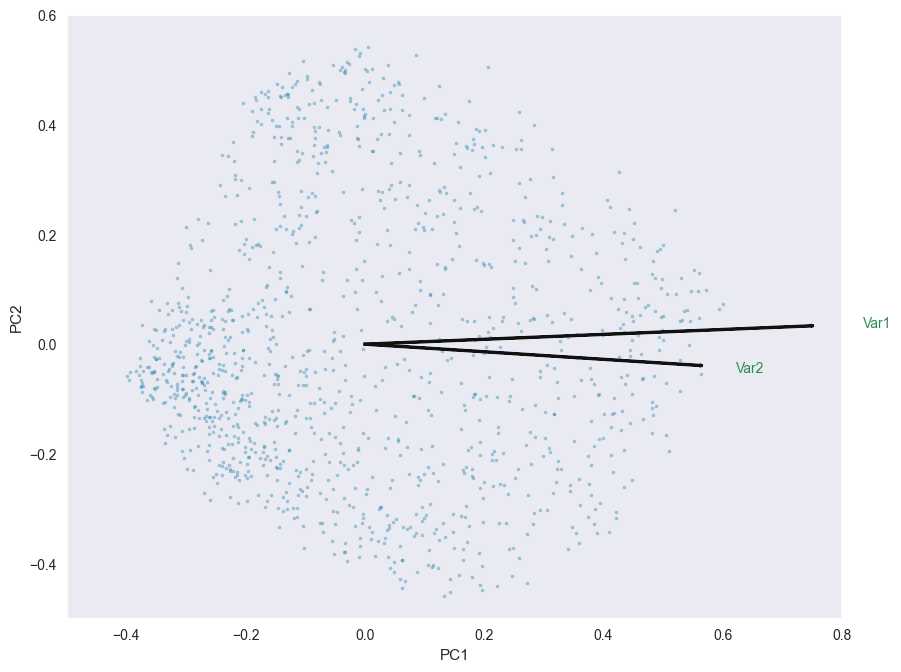

In [669]:
loads = pca.components_[:2].transpose()
coords = loads*np.sqrt(pca.explained_variance_).reshape(-1,1)

biPlot(pca_result[:,:2],coords[:2])
plt.show()

Distribution of Points: The points are widely spread on the graph, mainly along the X-axis, indicating that the first principal component has a significant influence on the variation of the data. However, the points are also distributed quite widely along the Y-axis, meaning that the second principal component also affects the data variation.

**Role of Variables:**

Var1: This arrow is long and points towards the right, indicating that Var1 has a strong positive correlation with the first principal component. This variable plays a major role in explaining the variation captured by this component.

Var2: This arrow is shorter and almost parallel to the X-axis, showing that Var2 has a certain but not as strong influence as Var1 on the first principal component. However, because it does not strongly align with the Y-axis, the influence of Var2 on the second principal component is not significant.

**Significance:**
Correlation between Variables and Principal Components: Var1 is crucial in explaining the variation in the data and may be the primary variable affecting the variability in observations. Var2 has less influence and may not be necessary to explain the primary variation in the data.

Data Exploration: The graph provides an overview of the relationships between variables and how they correlate with the variability in the data. This can be useful for identifying key variables for further analysis or model building.

This graph helps understand how variables impact the variability in the data and how individuals are distributed in PCA space, providing a basis for making decisions for further analysis.

In [670]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

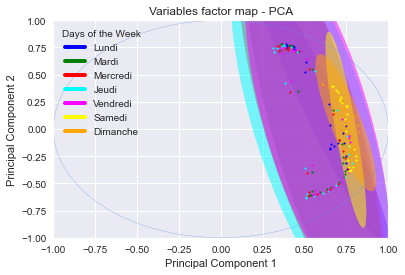

In [671]:
day_colors = {
    'Lundi': 'blue',
    'Mardi': 'green',
    'Mercredi': 'red',
    'Jeudi': 'cyan',
    'Vendredi': 'magenta',
    'Samedi': 'yellow',
    'Dimanche': 'orange',
}


day_ranges = {
    'Lundi': range(1, 25),
    'Mardi': range(25, 49),
    'Mercredi': range(49, 73),
    'Jeudi': range(73, 97),
    'Vendredi': range(97, 121),
    'Samedi': range(121, 145),
    'Dimanche': range(145, 169),
}
for day, col_range in day_ranges.items():

    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    
    color = day_colors[day]
    
    plot_point_cov(points, nstd=3, alpha=0.5, color=color)
for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    nom_value = int(nom)
    
    for day, col_range in day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)



plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))

plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items()]

plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')

plt.grid(True)
plt.show()

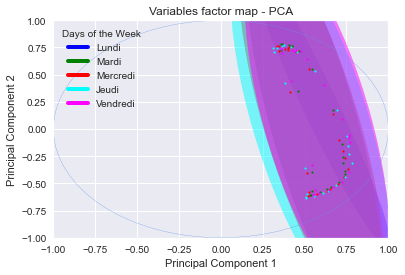

In [672]:
filtered_day_ranges = {day: col_range for day, col_range in day_ranges.items() if day in ['Lundi','Mardi', 'Mercredi', 'Jeudi', 'Vendredi']}
ax2 = axs[1]

for day, col_range in filtered_day_ranges.items():
    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    

    color = day_colors[day]
    

    plot_point_cov(points, nstd=3, alpha=0.5, color=color)
    

for i, j, nom in zip(coord1[24:120], coord2[24:120], data.columns[28:124]):
    nom_value = int(nom)

    for day, col_range in filtered_day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)


plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items() if day in ['Lundi','Mardi', 'Mercredi', 'Jeudi', 'Vendredi']]
plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')


plt.show()


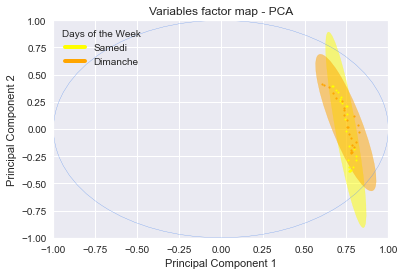

In [673]:
filtered_day_ranges = {day: col_range for day, col_range in day_ranges.items() if day in ['Samedi', 'Dimanche']}
ax2 = axs[1]

for day, col_range in filtered_day_ranges.items():
    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    

    color = day_colors[day]
    

    plot_point_cov(points, nstd=3, alpha=0.5, color=color)

for i, j, nom in zip(coord1[120:168], coord2[120:168], data.columns[124:172]):
    nom_value = int(nom)

    for day, col_range in filtered_day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)


plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items() if day in ['Samedi', 'Dimanche']]
plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')


plt.show()


Above, I attempted clustering on the new PCA data dimension. It can be observed that the similarity between the days of the week (as well as the weekends) is still maintained, indicating that dividing the data into clusters based on days is not effective.


In [674]:
scale  = data_scale.iloc[:,4:]

In [675]:
data1 = data.iloc[:,4:]

In [746]:
reduced = pca_result[:,:2]

## Clustering with K-means:

#### Selection of the number of clusters


In [747]:
# Define the function to get the version of OpenBLAS module
def get_openblas_version(dynlib):
    # Try to get the configuration info from the dynamic library
    try:
        # Get the configuration info using ctypes
        get_config = getattr(dynlib, "openblas_get_config", lambda: None)
        # Set the restype of get_config function to ctypes.c_char_p
        get_config.restype = ctypes.c_char_p
        # Call the get_config function and store the result
        config = get_config()
        # Check if the config info is not None
        if config is not None:
            # Return the config info
            return config
    # Handle the AttributeError exception
    except AttributeError:
        # Print an error message
        print("Error: Unable to get OpenBLAS configuration info")
    # Return None if the configuration info is ânot available
    return None

# Define the OpenBLASModule class
class OpenBLASModule:
    # Define the constructor method
    def __init__(self, filepath, prefix, user_api, internal_api):
        # Store the filepath, prefix, user_api, and internal_api
        self.filepath = filepath
        self.prefix = prefix
        self.user_api = user_api
        self.internal_api = internal_api
        # Load the dynamic library using ctypes
        self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
        # Get the version of the OpenBLAS module
        self.version = get_openblas_version(self._dynlib)

# Define the _ThreadpoolInfo class
class _ThreadpoolInfo:
    # Define the constructor method
    def __init__(self, user_api, prefixes, modules):
        # Initialize the user_api, prefixes, and modules
        self.user_api = [] if user_api is None else user_api
        self.prefixes = prefixes
        self.modules = []
        # Load the supported modules
        self._load_modules()

    # Define the method to load the modules
    def _load_modules(self):
        # Loop through the loaded libraries and store supported ones
        for filepath in sys.get_loaded_modules():
            # Try to find modules with dyld
            if sys.platform == "darwin":
                self._find_modules_with_dyld(filepath)
            # Try to find modules with EnumProcessModuleEx
            elif sys.platform == "win32":
                self._find_modules_with_enum_process_module_ex(filepath)

    # Define the method to find modules with dyld
    def _find_modules_with_dyld(self, filepath):
        # Check if the filepath contains the prefix or user_api
        if self.prefixes or self.user_api:
            # Decode the filepath from bytes to string
            filepath = filepath.decode("utf-8")
            # Make a module from the path
            self._make_module_from_path(filepath)

    # Define the method to make a module from the path
    def _make_module_from_path(self, filepath):
        # Check if the filepath contains the prefix or user_api
        if self.prefix in self.prefixes or self.user_api in self.user_api:
            # Get the module class from globals
            module_class = globals()[module_class]
            # Make a module from the path
            module = module_class(filepath, prefix, user_api, internal_api)
            # Append the module to the modules list
            self.modules.append(module)


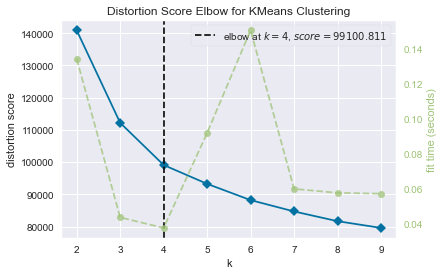

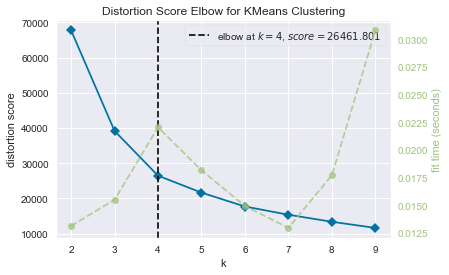

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [749]:
# Initialize the KMeans estimator for the original data
kmeans0 = KMeans(init='k-means++', n_init=5, max_iter=100, random_state=42)
# Initialize the KElbowVisualizer with the KMeans estimator and the range of K values
visualizer0 = KElbowVisualizer(kmeans0, k=(2, 10))

# Fit the visualizer on the scaled data
visualizer0.fit(scale )
# Set the title for the Elbow plot of the original data
visualizer0.set_title('Elbow Plot for Original Data')
# Show the Elbow plot
visualizer0.show()

# Initialize the KMeans estimator for the reduced data
kmeans1 = KMeans(init='k-means++', n_init=5, max_iter=100, random_state=42)
visualizer1 = KElbowVisualizer(kmeans1, k=(2, 10))
visualizer1.fit(reduced)
# Set the title for the Elbow plot of the reduced data
visualizer1.set_title('Elbow Plot for Reduced Data')
visualizer1.show()


**We see that, in both data sets, the Score Elbow method recommends choosing 4 clusters**

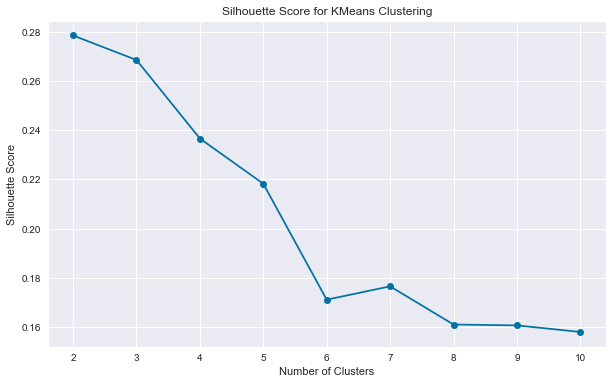

In [750]:
# Define a range of cluster numbers to evaluate
range_n_clusters = range(2, 11)

# Initialize an empty list to store silhouette scores for each cluster number
silhouette_scores = []

# Iterate through the range of cluster numbers
for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    
    # Fit KMeans to the data and predict cluster labels
    cluster_labels = kmeans.fit_predict(scale)
    
    # Calculate the silhouette score for the current clustering
    silhouette_avg = silhouette_score(scale , cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


**From here, we can conclude that we can try dividing the data into 2 to 5 clusters to see which division is most effective.**

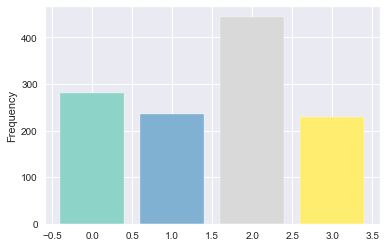

In [755]:
K = 4

kmeans_pca = KMeans(n_clusters=K, random_state=0)
km_pca = kmeans_pca.fit_predict(reduced)

# ----- #

cmap = plt.get_cmap('Set3',K)
plt.bar(*np.unique(km_pca, return_counts=True), color=cmap.colors)
plt.ylabel("Frequency")
plt.show()

**Quantitative heterogeneity**: Differences in the number of data points between clusters may suggest that some clusters have characteristics that are more common in the original data, or may indicate that the cluster covers a larger region of the data space

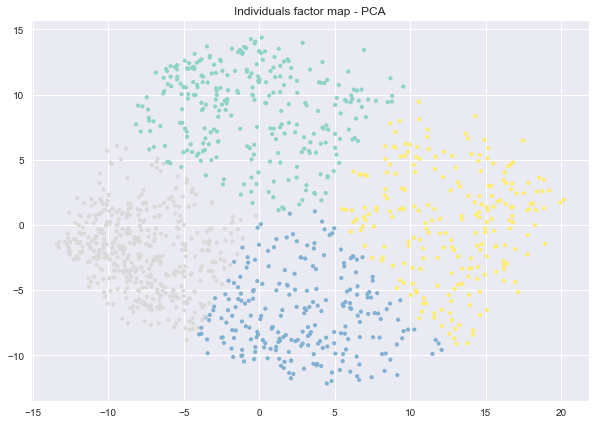

In [756]:
plt.figure(figsize=(10,7))
plt.scatter(reduced[:,0], reduced[:,1], c=km_pca, s=10, linewidths=1, cmap=cmap)
plt.title("Individuals factor map - PCA")
plt.show()

### Appliquer la méthode de clustering K-Means sur l'ensemble de données d'origine

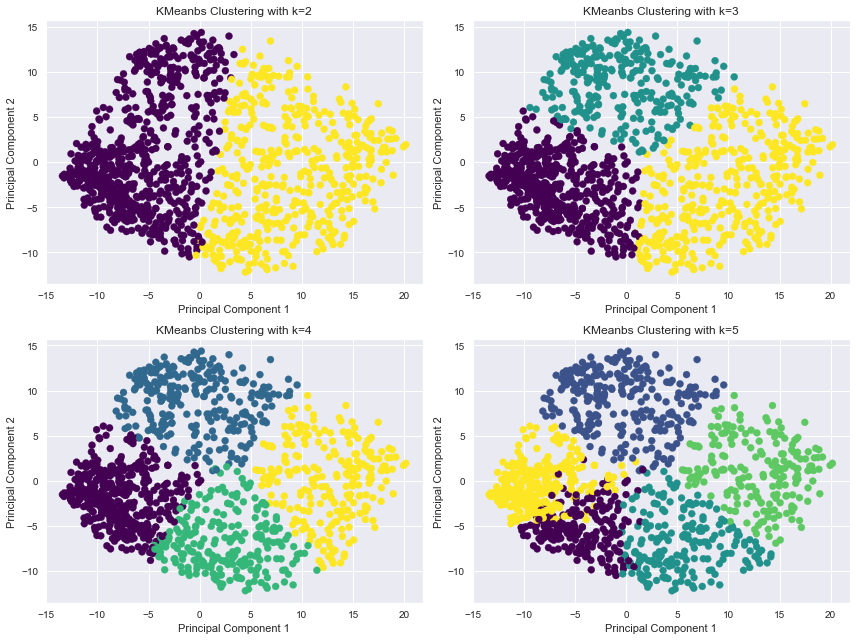

In [757]:
cluster_results1 = {}
cluster_plots = {}

# Perform KMeans clustering for each k value
k_values = [ 2,3, 4,5]
for k in k_values:
    # Initialize KMeans with the specified number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit KMeans to the scaled data
    kmeans.fit(data1)
    
    # Store cluster labels
    cluster_results1[str(k)] = kmeans.labels_

# Visualize cluster results (you can adjust the plotting method based on your preference)
plt.figure(figsize=(12, 9))
for i, k in enumerate(k_values, 1):
    plt.subplot(2, 2, i)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_results1[str(k)], cmap='viridis')
    plt.title(f'KMeanbs Clustering with k={k}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


We notice that, if divided into 3 or 4 clusters, we see a pretty good division between the clusters, however in the case of K=5, we see that there is a lot of overlap between the clusters.

### Apply K Means clustering method on PCA dataset

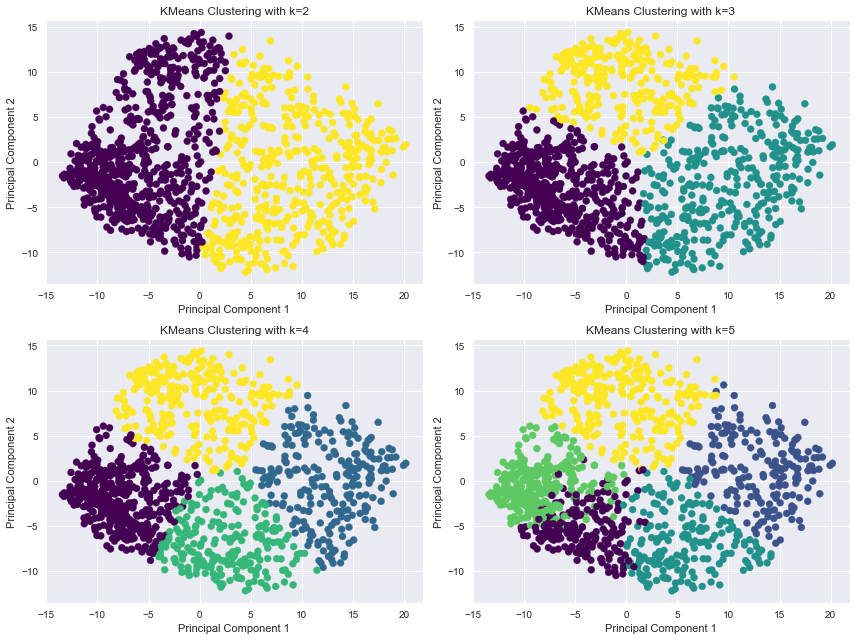

In [683]:
cluster_results = {}
cluster_plots = {}


# Perform KMeans clustering for each k value
k_values = [ 2,3,4,5]
for k in k_values:
    # Initialize KMeans with the specified number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced)
    # Store cluster labels
    cluster_results[str(k)] = kmeans.labels_

# Visualize cluster results (you can adjust the plotting method based on your preference)
plt.figure(figsize=(12, 9))
for i, k in enumerate(k_values, 1):
    plt.subplot(2, 2, i)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_results[str(k)], cmap='viridis')
    plt.title(f'KMeans Clustering with k={k}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

We notice that, if divided into 3 or 4 clusters, we see a pretty good division between the clusters, however in the case of K=5, we see that there is a lot of overlap between the clusters

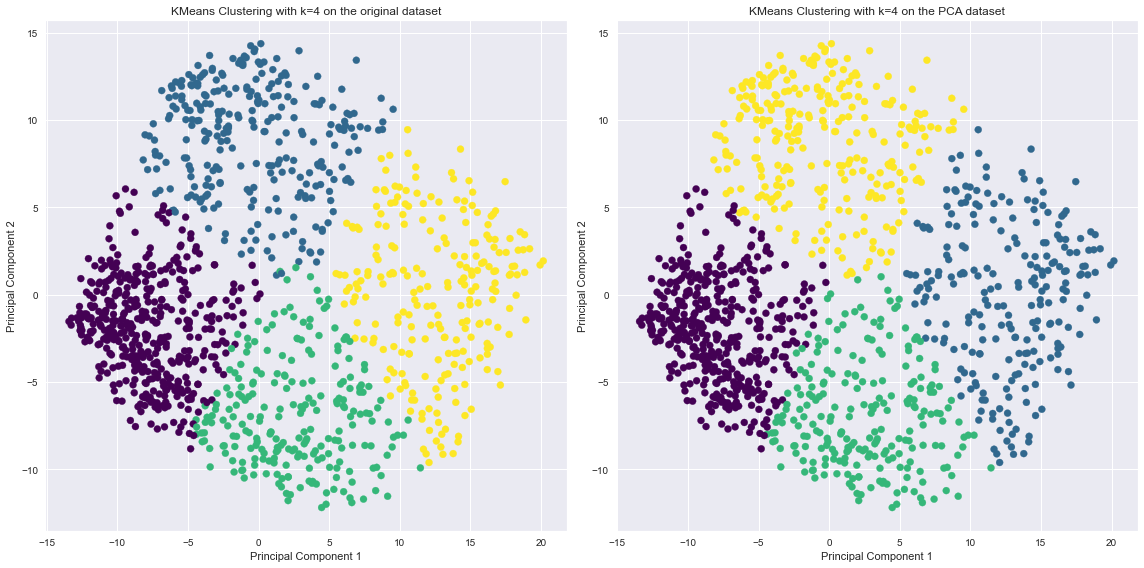

In [758]:
k = 4
plt.figure(figsize = (16,8))

plt.subplot(1, 2, 1)
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_results1[str(k)], cmap='viridis')
plt.title(f'KMeans Clustering with k={k} on the original dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2) 
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_results[str(k)], cmap='viridis')
plt.title(f'KMeans Clustering with k={k} on the PCA dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

And we can see that the clustering efficiency of the K-means method is not too different between the original data set and the PCA data set. There are only slight differences in the points between cluster boundaries

In [759]:
def matchClasses(classif1, classif2):
    cm = confusion_matrix(classif1, classif2)
    K = cm.shape[0]
    a, b = np.zeros(K), np.zeros(K)
    for j in range(K):
        for i in range(K):
            if (a[j] < cm[i,j]):
                a[j] = cm[i,j]
                b[j] = i 
    a = a.astype(int)
    b = b.astype(int)
                                             
    print ("")
    print ("Classes size:", a)
    print ("Class (in the classif1 numbering):", b)
    print ("")
    
    table = cm.copy()
    for i in range(K):
        table[:,b[i]] = cm[:,i]   
        
    clusters = classif2.copy()
    n = classif2.shape[0]
    for i in range(n):
        for j in range(K):
            if (classif2[i] == j):
                clusters[i] = b[j]
        
    return table, clusters


Classes size: [276 226 435 229]
Class (in the classif1 numbering): [3 1 2 0]



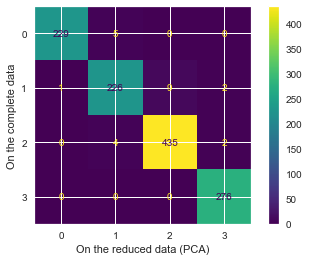

In [760]:
kmeans_full = KMeans(n_clusters=4, init='k-means++', n_init=10)
km_full = kmeans_full.fit_predict(data1)
km_pca = kmeans_pca.fit_predict(reduced)

cm, clusters_pca_sorted = matchClasses(km_full, km_pca)

ConfusionMatrixDisplay(cm).plot()
plt.xlabel('On the reduced data (PCA)')
plt.ylabel('On the complete data')
plt.show()

From the confusion matrix, we can conclude that the K-means method works as effectively on the PCA dataset as on the original dataset. This means that the PCA method was very effective in this case as it helped reduce the data dimensionality but still maintained almost the same efficiency.

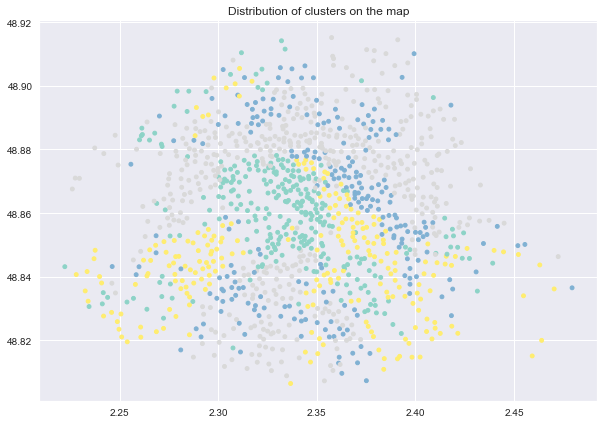

In [761]:
K=4
plt.figure(figsize=(10,7))
cmap = plt.get_cmap('Set3',K)
plt.scatter(coord['longitude'], coord['latitude'], c=km_pca, s=15, linewidths=1, cmap=cmap)
plt.title("Distribution of clusters on the map")
plt.show()

Here, by plotting on a Google map, we see that group 2 stations are often located near the Seine. Group 3 stations are generally far from the center of Paris, while most Group 4 stations are located in the center of Paris.

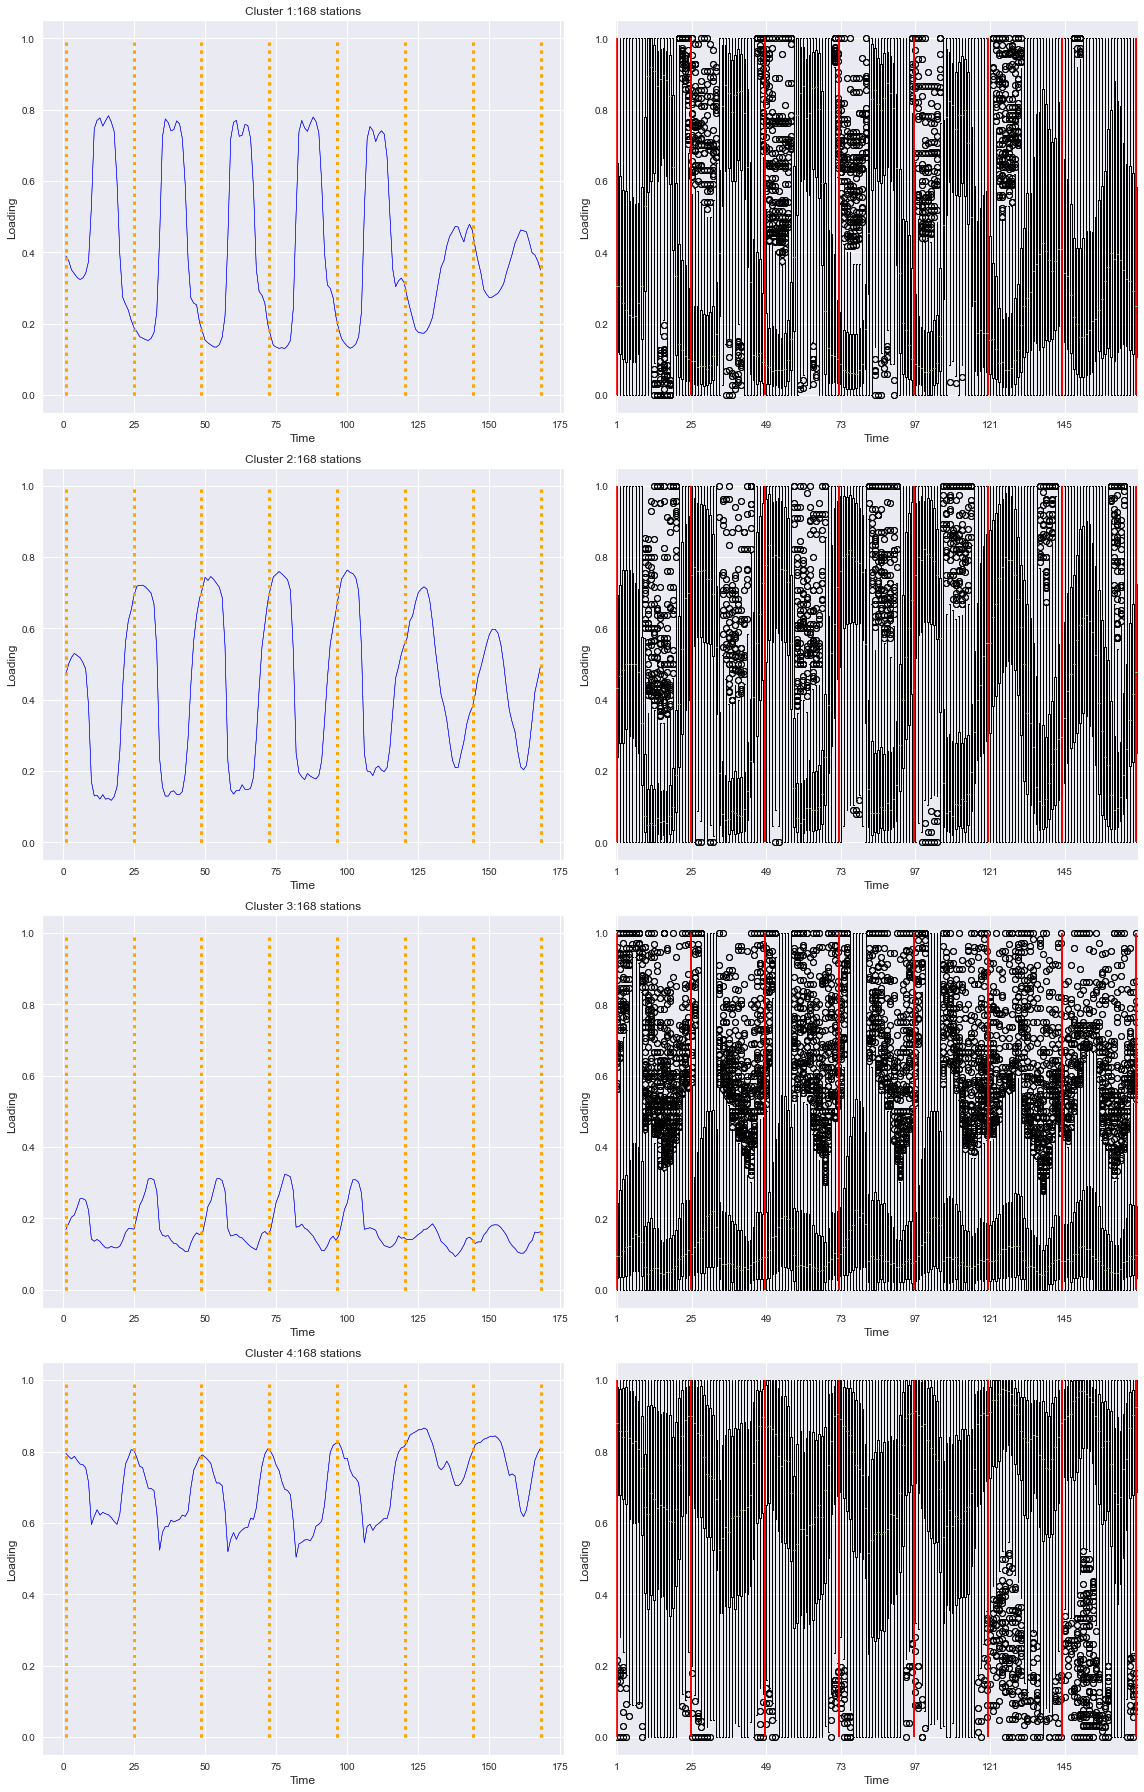

In [762]:
n_steps = loading.shape[1]
time    = np.linspace(1, n_steps, n_steps)
K=4
fig, axs = plt.subplots(K, 2, figsize = (16,25))
for i in range(K):
    for j in range(2):
        load_clust_i = np.squeeze(loading_data[np.where(km_pca==i),:168])
        avg_hourly = np.mean(load_clust_i,axis=0)
        axs[i, 0].plot(time, avg_hourly, linewidth = 0.5, color = 'blue')
        axs[i, 0].set_title('Cluster '+str(i+1)+':'+str(np.shape(load_clust_i)[1])+' stations', fontsize = 12)
        axs[i, 0].vlines(x = np.linspace(1, n_steps, 8), ymin = 0, ymax = 1, 
                         colors = "orange", linestyle = "dotted", linewidth = 3)
        
        axs[i, 1].boxplot(load_clust_i)
        axs[i, 1].set_xticks(np.arange(1, 168+24, 24), labels = np.arange(1, 168+24, 24))
        axs[i, 1].vlines(x = np.linspace(1, loading.columns.size, 8), ymin = 0, ymax = 1, colors = "red")
        
for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
plt.tight_layout()
plt.show()

It can be seen that clusters 1 and 2 represent the station groups with high variation during the day. In cluster 1, loadings are high at night and low during the day, while in cluster 4, it is the opposite. 

Clusters 3 and 4 represent groups of stations with low variation during the day. In cluster 4, loadings are high both during the day and at night, meaning that stations near the Seine tend to have high loadings. In cluster 3, loadings are low throughout the day, meaning that stations located on hills or far from the city center tend to have low loadings.

There is a difference between Saturday, Sunday and weekdays. Loading variations are less during the two days of the weekend compared to the other days.

## Clustering with HAC:

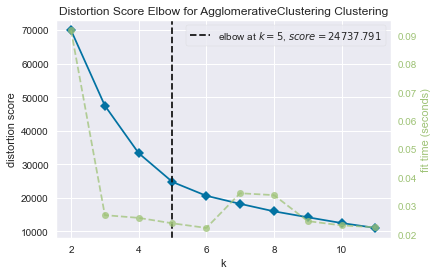

In [763]:
ac = AgglomerativeClustering(linkage="ward", compute_distances=True)
visualizer = KElbowVisualizer(ac, k=(2,12))

visualizer.fit(reduced)       
visualizer.show()   

plt.show()

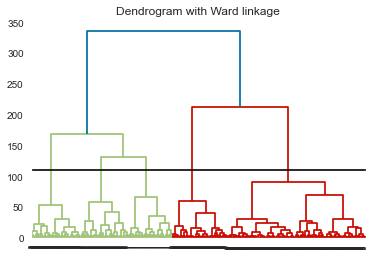

In [764]:
K = 5

ac = AgglomerativeClustering(n_clusters=K, compute_distances=True, linkage="ward")
hac_pca = ac.fit(reduced)

children = ac.children_
distances = ac.distances_
n_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.c_[children, distances, n_observations]

sch.dendrogram(linkage_matrix, labels=ac.labels_)

# Cutting the dendrogram to get K classes
max_d = .5*(ac.distances_[-K]+ac.distances_[-K+1])
plt.axhline(y=max_d, c='k')

plt.title("Dendrogram with Ward linkage")
plt.show()

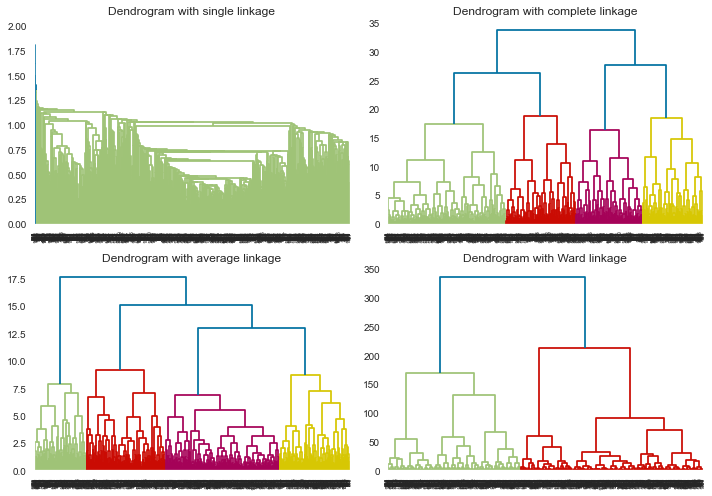

In [765]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
linkage_matrix = sch.linkage(reduced, method='single')
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram with single linkage")

plt.subplot(2,2,2)
linkage_matrix = sch.linkage(reduced, method='complete')
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram with complete linkage")

plt.subplot(2,2,3)
linkage_matrix = sch.linkage(reduced, method='average')
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram with average linkage")

plt.subplot(2,2,4)
linkage_matrix = sch.linkage(reduced, method='ward')
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram with Ward linkage")

plt.tight_layout()
plt.show()

Ward linkage is generally less affected by noise and produces uniform clusters, so it is often preferred. In this particular case, Ward linkage can be considered the best method due to its ability to create uniform and tight clusters.

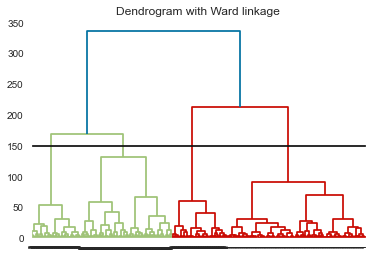

In [766]:
K = 4

ac = AgglomerativeClustering(n_clusters=K, compute_distances=True, linkage="ward")
hac_pca = ac.fit(reduced)

children = ac.children_
distances = ac.distances_
n_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.c_[children, distances, n_observations]

sch.dendrogram(linkage_matrix, labels=ac.labels_)

# Cutting the dendrogram to get K classes
max_d = .5*(ac.distances_[-K]+ac.distances_[-K+1])
plt.axhline(y=max_d, c='k')

plt.title("Dendrogram with Ward linkage")
plt.show()

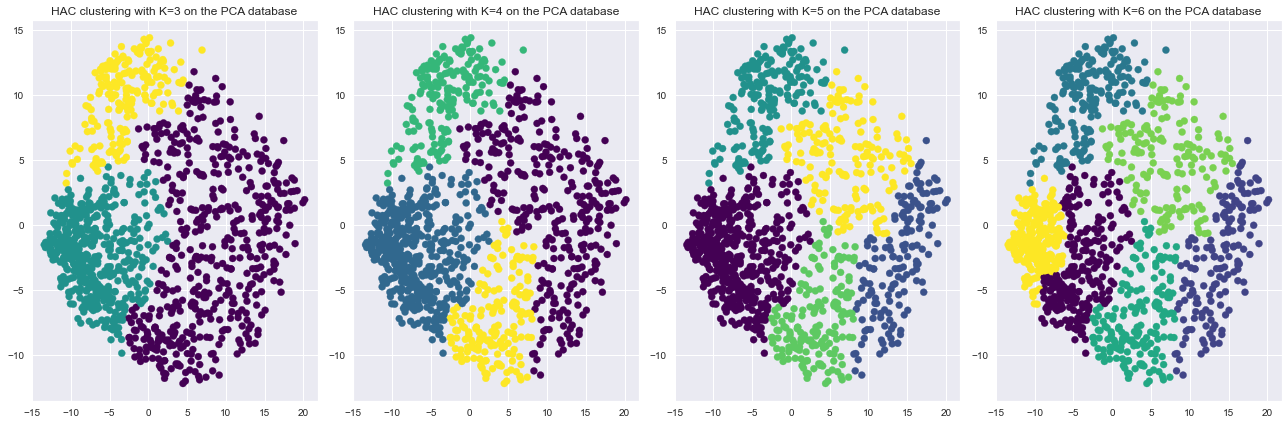

In [767]:

plt.figure(figsize=(18, 6))  
for K in range(3, 7):
    c
plt.show()


We notice that, in the HAC method, the clusters are not clearly divided like Kmeans. In all cases from 3 to 6 clusters, we see quite significant intermixing between clusters. Here we see that dividing into 4 or 5 clusters seems better than the other 2 cases


Classes size: [175 419 182 134]
Class (in the classif1 numbering): [1 2 0 3]



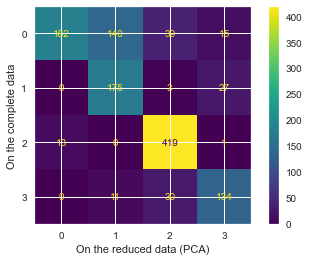

In [770]:
hac_full = AgglomerativeClustering(n_clusters=4, linkage='ward')
hac_full = hac_full.fit_predict(data1)

hac_pca = AgglomerativeClustering(n_clusters=4, linkage='ward')
hac_pca = hac_pca.fit_predict(reduced)

cm, clusters_pca_sorted = matchClasses(hac_full, hac_pca)

ConfusionMatrixDisplay(cm).plot()
plt.xlabel('On the reduced data (PCA)')
plt.ylabel('On the complete data')
plt.show()

Here we can see that PCA is not really effective in the case of HAC clustering, we see that the accuracy is not high because the False Positive index and False Negative index are still large at some clusters.

This can be explained as follows:

+ Non-linear nature of data: When data is non-linear or heterogeneous, applying HAC directly on the original data and after dimensionality reduction can lead to different clusters. This can increase the differences between clustering and lead to large off-diagonal values in the confusion matrix.

+ Information loss: When performing dimensionality reduction operations such as PCA, part of the information in the data may be lost. This can lead to a decrease in the performance of the clustering algorithm on the data after dimensionality reduction.

+ Imbalance between classes or clusters: If there is imbalance between classes or clusters in the data, this can give rise to off-diagonal values of the confusion matrix. In this case, less common classes or clusters may be misclassified more than popular classes or clusters.

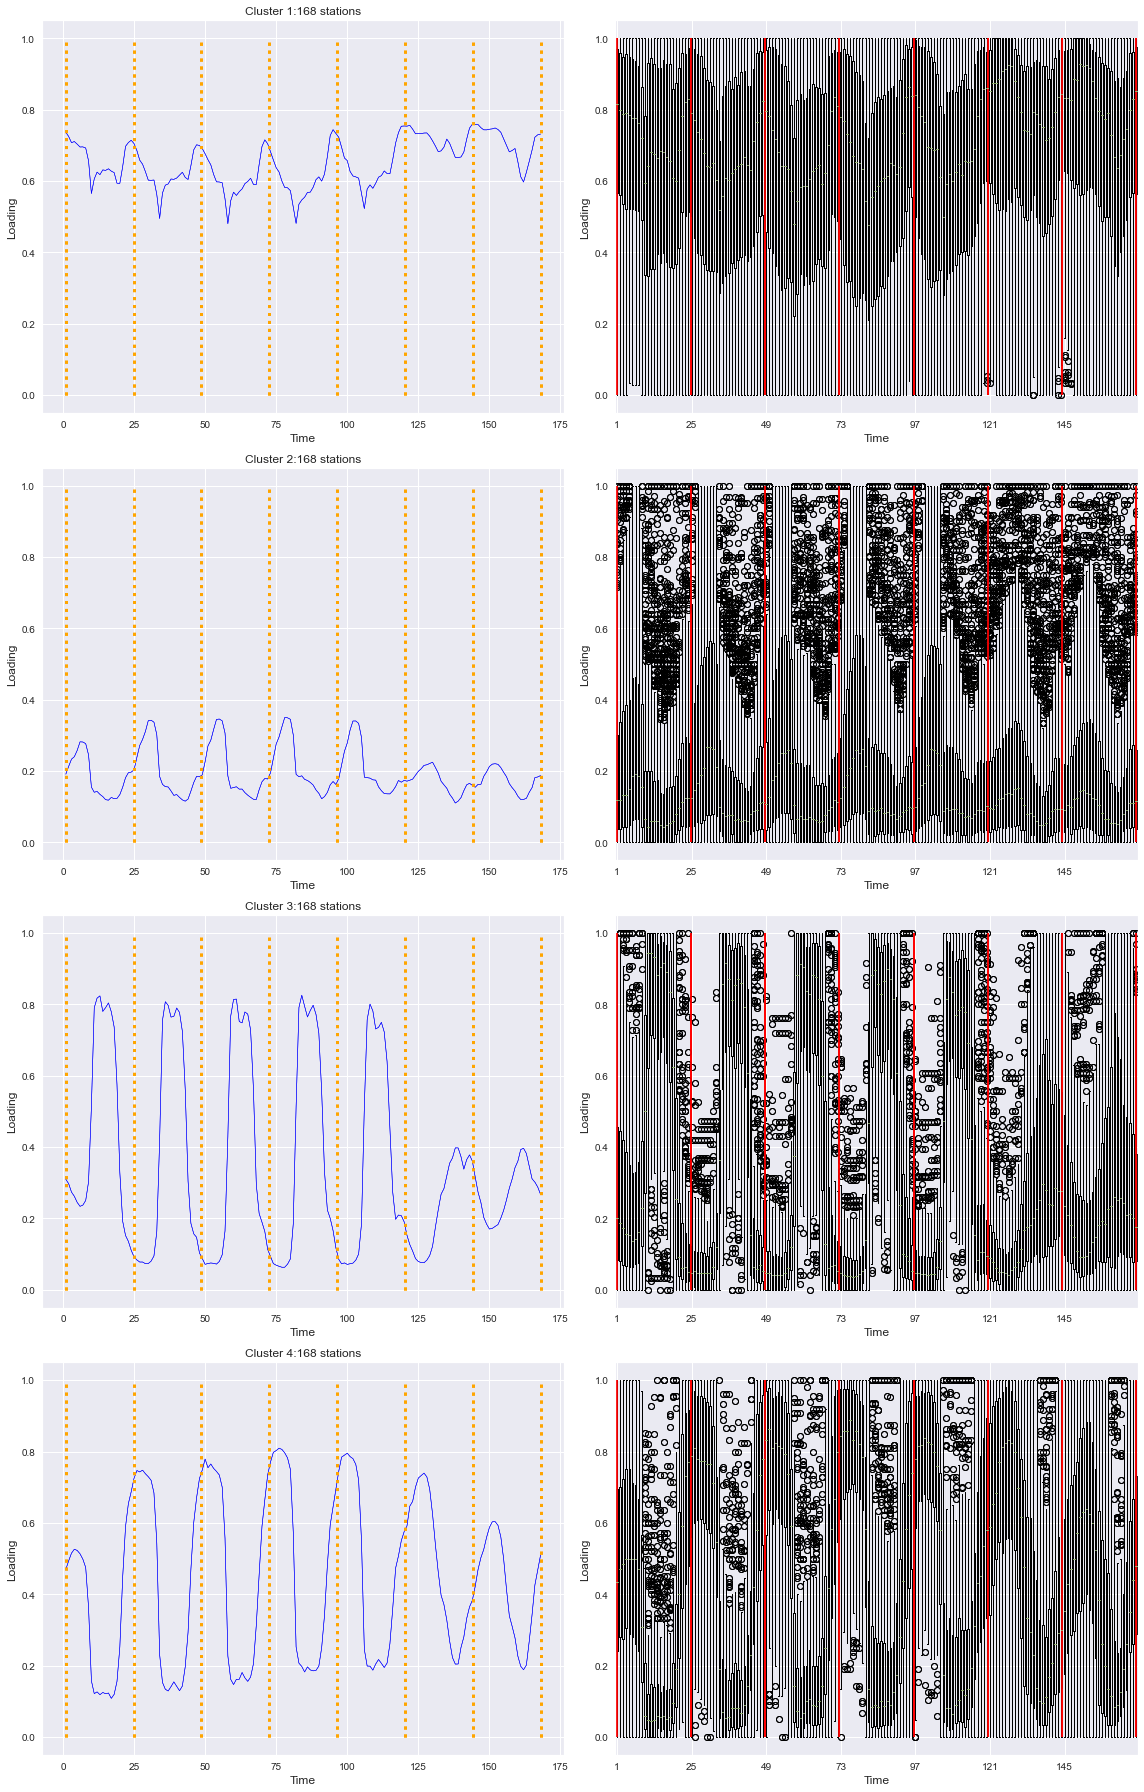

In [771]:
ac = AgglomerativeClustering(n_clusters=4, compute_distances=True, linkage="ward")
hac_pca = ac.fit_predict(reduced)


n_steps = loading.shape[1]
time    = np.linspace(1, n_steps, n_steps)
K=4
fig, axs = plt.subplots(K, 2, figsize = (16,25))
for i in range(K):
    for j in range(2):
        load_clust_i = np.squeeze(loading_data[np.where(hac_pca==i),:168])
        avg_hourly = np.mean(load_clust_i,axis=0)
        axs[i, 0].plot(time, avg_hourly, linewidth = 0.5, color = 'blue')
        axs[i, 0].set_title('Cluster '+str(i+1)+':'+str(np.shape(load_clust_i)[1])+' stations', fontsize = 12)
        axs[i, 0].vlines(x = np.linspace(1, n_steps, 8), ymin = 0, ymax = 1, 
                         colors = "orange", linestyle = "dotted", linewidth = 3)
        
        axs[i, 1].boxplot(load_clust_i)
        axs[i, 1].set_xticks(np.arange(1, 168+24, 24), labels = np.arange(1, 168+24, 24))
        axs[i, 1].vlines(x = np.linspace(1, loading.columns.size, 8), ymin = 0, ymax = 1, colors = "red")
        
for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
plt.tight_layout()
plt.show()

Here we draw the boxplot of the clusters. Clusters with clearly different characteristics resemble K-means clustering.

It can be seen that clusters 3 and 4 represent the station groups with high variation during the day. In cluster 4, loadings are high at night and low during the day, while in cluster 3, it is the opposite. There is a difference between Saturday, Sunday and weekdays. Loading variations are less during the two days of the weekend compared to the other days.

Clusters 1 and 2 represent groups of stations with low variation during the day. In cluster 1, loadings are high both during the day and at night. In cluster 2, loadings are low throughout the day. 

## Clustering with GMM:


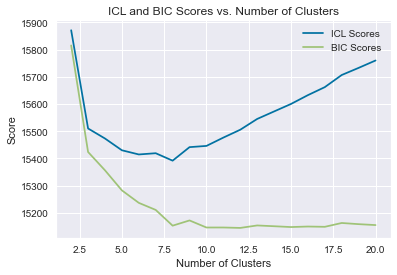

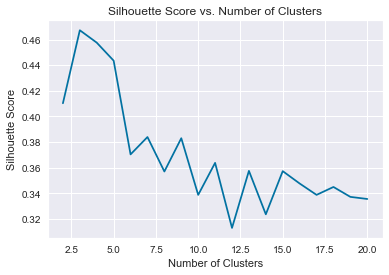

In [772]:
# Initialize lists to store results
ICL_scores = []
BIC_scores = []
silhouette_scores = []

# Loop through different number of clusters
for G in range(2, 21):
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=G, n_init=3)
    gmm.fit(reduced)
    
    # Calculate ICL and BIC scores
    ICL_score = gmm.bic(reduced)
    BIC_score = gmm.aic(reduced)
    
    # Calculate silhouette score
    labels = gmm.predict(reduced)
    silhouette = silhouette_score(reduced, labels)
    
    # Append scores to lists
    ICL_scores.append(ICL_score)
    BIC_scores.append(BIC_score)
    silhouette_scores.append(silhouette)

# Plot ICL and BIC scores
plt.plot(range(2, 21), ICL_scores, label='ICL Scores')
plt.plot(range(2, 21), BIC_scores, label='BIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('ICL and BIC Scores vs. Number of Clusters')
plt.legend()
plt.show()

# Plot silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()


1. ICL and BIC Scores vs. Number of Clusters
ICL Scores (Integrated Complete Likelihood):

The curve of ICL Scores shows that the score value decreases as the number of clusters increases from 2.5 to about 6 clusters, then fluctuates and increases slightly when the number of clusters exceeds 8.
The lowest scores of ICL Scores appear around about 6 clusters. This suggests that the model with about 6 clusters may be the best choice according to the ICL criteria.

BIC Scores (Bayesian Information Criterion):

The BIC Scores curve also shows a decreasing trend as the number of clusters increases, with the lowest score also appearing around 11 clusters.
Lower BIC Scores correspond to better models. Thus, a cluster number of about 11 may be the optimal choice according to the BIC criterion. This is a completely unreasonable result, so the BIC criterion is not correct in this case.

2. Silhouette Score vs. Number of Clusters
Silhouette Score:
The Silhouette Score curve shows a peak (~0.46) when the number of clusters is about 3.
After this point, the Silhouette Score tends to decrease as the number of clusters increases. Despite some fluctuations, the Silhouette Score did not rebound and remained lower than its initial value.
Higher Silhouette Score values represent more clearly defined clusters. Therefore, cluster number 3 may be the best choice according to the Silhouette criterion.

**General comments**

Both ICLs suggest that about 6 clusters are the optimal choice, as these scores are lowest in this region. A lower score indicates a better model with that number of clusters.
However, Silhouette Score suggests that about 3 clusters is the best choice as the value is highest in this region, indicating that the clusters are more clearly defined and the cluster separation is better.
More detailed analysis:

If your main goal is to have clear and easily identifiable clusters, then according to Silhouette Score, you should choose about 2.5 to 3 clusters.
If the goal is to have the best model according to statistical criteria, ICL suggests that you choose about 6 clusters.

So we will try the case of dividing 3,4,5 and 6 clusters

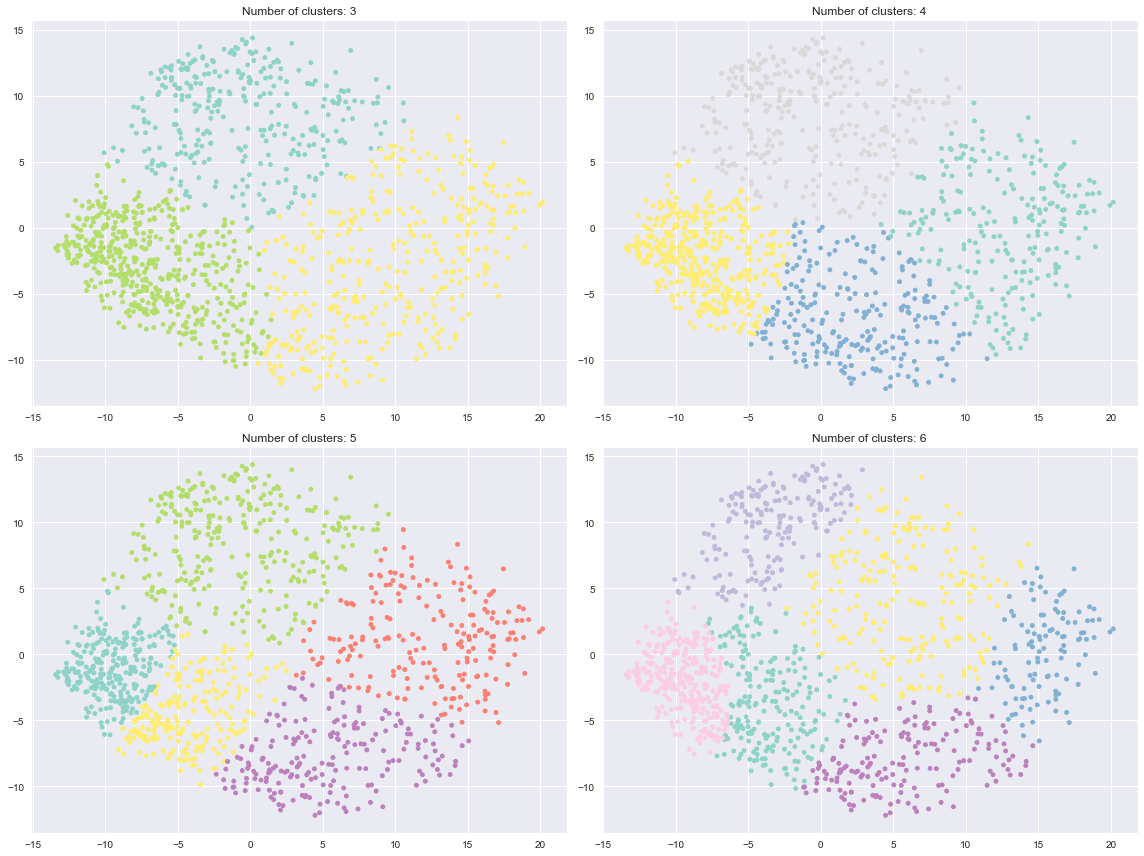

In [773]:
K_values = [3, 4, 5,6]
plt.figure(figsize=(16, 12))
for K in K_values:
    cmap = plt.get_cmap('Set3', K)
    gmm = GaussianMixture(n_components=K, n_init=3)
    clusters_gmm = gmm.fit_predict(reduced)
    plt.subplot(2,2,K-2)   
    plt.scatter(reduced[:,0], reduced[:,1], c=clusters_gmm, s=15, linewidths=1, cmap=cmap)
    plt.title("Number of clusters: {}".format(K))
plt.tight_layout()
plt.show()   


Using the Gaussian Mixture Model (GMM) method in the case of data that has been reduced in dimension using Principal Component Analysis (PCA) brings many benefits, especially when working with high-dimensional data. Here are the main reasons why using PCA before applying GMM is a good idea:

#### 1. Reduce computational complexity
- **GMM** is a complex statistical method that requires the estimation of many parameters (means, variances and covariance matrices for each Gaussian component).
- When the data has high dimensionality, the number of parameters that need to be estimated will increase greatly, increasing computational costs and possibly leading to the problem of overfitting.
- **PCA** helps reduce the dimensionality of data while still retaining most of the important information. This helps reduce computational complexity and makes the GMM model training process faster and more efficient.

#### 2. Improve model accuracy and efficiency
- **High dimensional data** often contains a lot of unnecessary noise information, which can reduce the accuracy of the GMM model.
- **PCA** helps remove noise and retain principal components, making data cleaner and easier to cluster.
- Dimensionality reduction using PCA before applying GMM can help improve model accuracy and efficiency by focusing on key components of the data.

#### 3. Avoid multicollinearity problem
- **Multicollinearity** (multicollinearity) occurs when features in the data have a highly linear relationship, leading to instability in parameter estimates.
- **PCA** helps eliminate multicollinearity by creating uncorrelated principal components. This helps improve the stability and reliability of the parameters estimated in the GMM model.

Thanks to the benefits of PCA, we can see that the data of cases K=4, K=5 is divided quite clearly, with very little confusion between the two clusters. Below is a demonstration that using GMM on the original data leads to poor clustering when there are many overlaps between clusters.

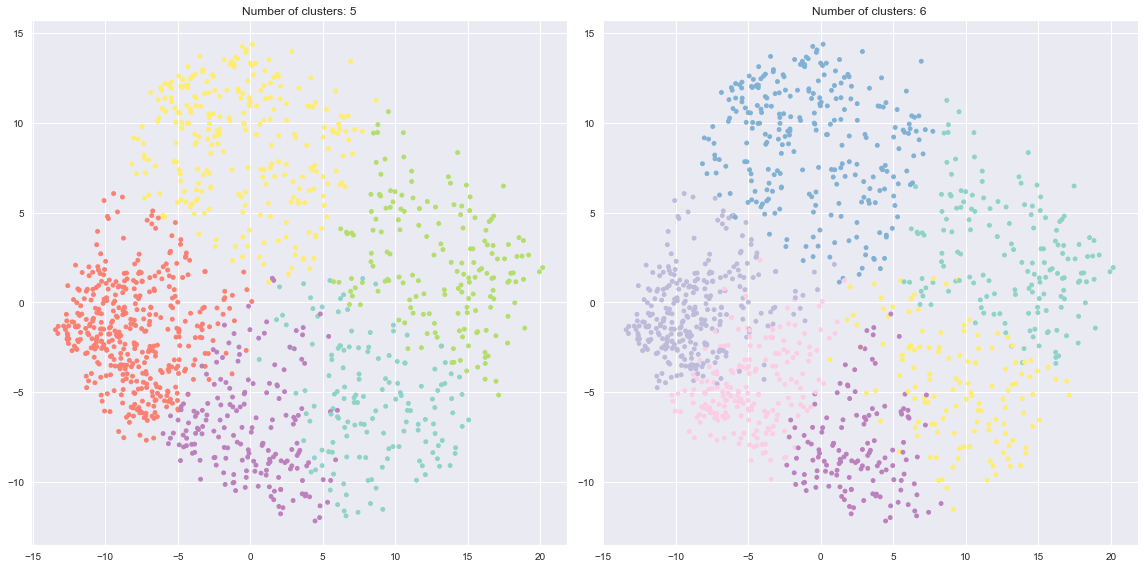

In [774]:
K_values = [ 5,6]
plt.figure(figsize=(16, 8))
for K in K_values:
    cmap = plt.get_cmap('Set3', K)
    gmm = GaussianMixture(n_components=K, n_init=3)
    clusters_gmm = gmm.fit_predict(data1)
    plt.subplot(1,2,K-4)   
    plt.scatter(reduced[:,0], reduced[:,1], c=clusters_gmm, s=15, linewidths=1, cmap=cmap)
    plt.title("Number of clusters: {}".format(K))
plt.tight_layout()
plt.show()   


In [775]:
gmm = GaussianMixture(n_components=4, n_init=3)
clusters_gmm = gmm.fit_predict(reduced)

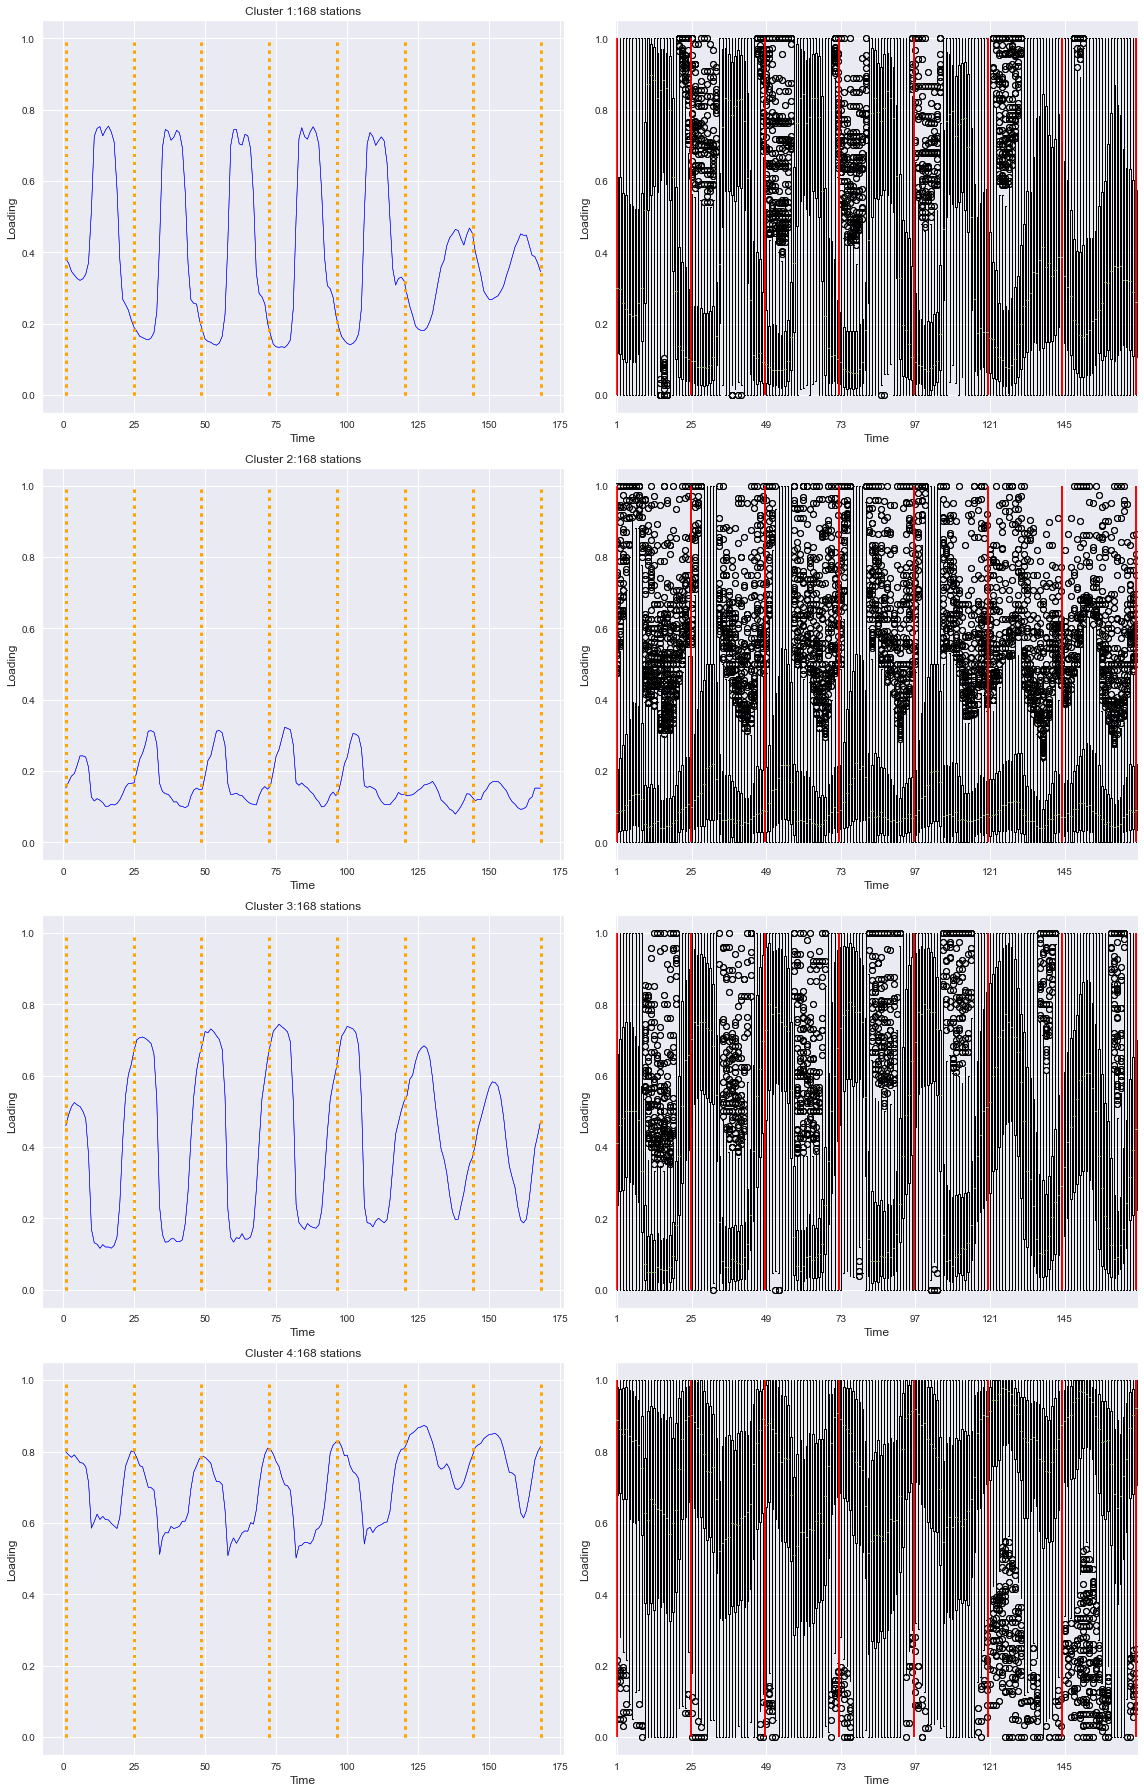

In [776]:
n_steps = loading.shape[1]
time    = np.linspace(1, n_steps, n_steps)
K=4
fig, axs = plt.subplots(K, 2, figsize = (16,25))
for i in range(K):
    for j in range(2):
        load_clust_i = np.squeeze(loading_data[np.where(clusters_gmm==i),:168])
        avg_hourly = np.mean(load_clust_i,axis=0)
        axs[i, 0].plot(time, avg_hourly, linewidth = 0.5, color = 'blue')
        axs[i, 0].set_title('Cluster '+str(i+1)+':'+str(np.shape(load_clust_i)[1])+' stations', fontsize = 12)
        axs[i, 0].vlines(x = np.linspace(1, n_steps, 8), ymin = 0, ymax = 1, 
                         colors = "orange", linestyle = "dotted", linewidth = 3)
        
        axs[i, 1].boxplot(load_clust_i)
        axs[i, 1].set_xticks(np.arange(1, 168+24, 24), labels = np.arange(1, 168+24, 24))
        axs[i, 1].vlines(x = np.linspace(1, loading.columns.size, 8), ymin = 0, ymax = 1, colors = "red")
        
for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Loading', fontsize = 12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
plt.tight_layout()
plt.show()

We see that groups 3 and 4 tend to change greatly over time. However, they tend to change in opposite directions, group 3 increases during the day and decreases at night, group 4 is the opposite.
Meanwhile, group 1 and group 2 have small changes, but group 1 always keeps the load at a high level while group 2 always keeps the load at a low level.

## Comparison of clustering algorithms


### Visualize Kmeans versus GMM components

In [777]:
def plotKmeans(kmeans, data, n_clusters=4):
    kmeans.fit(data)
    clusters_kmeans = kmeans.predict(data)
    plt.figure(figsize=(15, 7))

    ax = plt.gca()
    ax.axis('equal')
    cmap = plt.get_cmap('Set3', n_clusters)

    # plot the input data
    ax.scatter(data[:, 0], data[:, 1], c=clusters_kmeans, s=7, linewidths=1, cmap=cmap)
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radius = [cdist(data[clusters_kmeans == i], [center]).max() for i, center in enumerate(centers)]
    for i in range(n_clusters):
        ax.add_patch(plt.Circle(centers[i], radius[i], fc=cmap.colors[i], alpha=0.3))

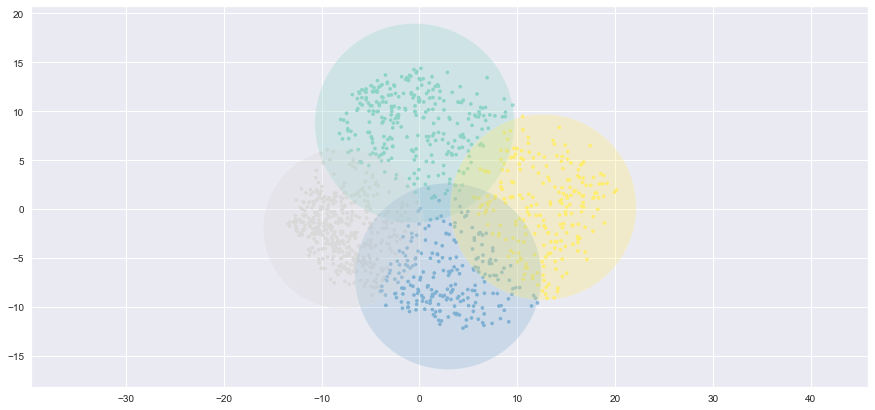

In [778]:
K = 4
kmeans = KMeans(n_clusters=K)

plotKmeans(kmeans, reduced)

In [779]:
def draw_ellipse(mean, covariance, alpha, ax, col='#CCCCCC'):
    """Draw an ellipse with a given position and covariance"""    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    ax.add_patch(Ellipse(mean, 4*width, 4*height, angle=angle, alpha=alpha, fc=col))

In [780]:
def plotGMM(gmm, data, n_clusters=4):
    gmm.fit(data)
    clusters_gmm = gmm.predict(data)
    plt.figure(figsize=(15, 7))

    ax = plt.gca()
    ax.axis('equal')
    cmap = plt.get_cmap('Set3', n_clusters)
    
    # plot the input data
    ax.scatter(data[:, 0], data[:, 1], c=clusters_gmm, s=7, linewidths=1, cmap=cmap)
    
    # w_factor = 0.2 / gmm.weights_.max()
    for i in range(n_clusters):
        mean = gmm.means_[i,:2]
        covariance = gmm.covariances_[i,:2,:2]
        w = gmm.weights_[i]
        draw_ellipse(mean, covariance, w, ax, cmap.colors[i])

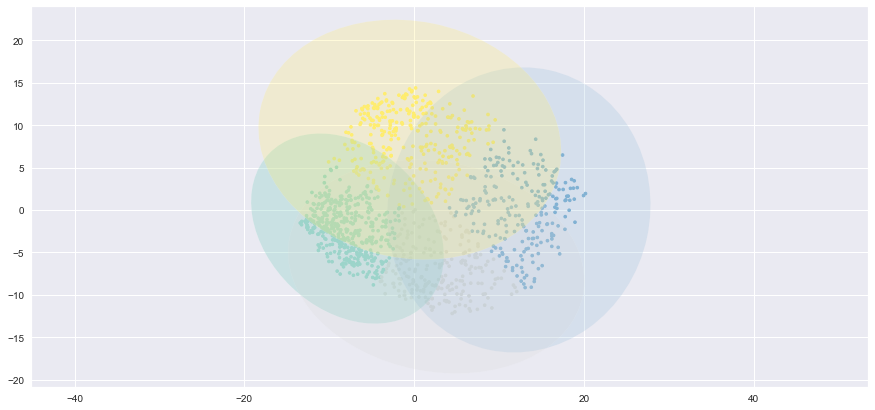

In [781]:
K = 4
gmm = GaussianMixture(n_components=K, init_params='kmeans')

plotGMM(gmm, reduced)

### Comparison between methods on PCA dataset

In [782]:
K=4 
hac_pca = AgglomerativeClustering(n_clusters=K, linkage='ward')
clusters_hac = hac_pca.fit_predict(reduced)

kmeans = KMeans(n_clusters=K, random_state=42)
clusters_kmeans = kmeans.fit_predict(reduced)

gmm = GaussianMixture(n_components=K)
clusters_gmm = gmm.fit_predict(reduced)

silhouette_kmeans = silhouette_score(reduced, clusters_kmeans)
silhouette_gmm = silhouette_score(reduced, clusters_gmm)
silhouette_hac = silhouette_score(reduced, clusters_hac)

print("Silhouette score for KMeans:", silhouette_kmeans)
print("Silhouette score for GMM:", silhouette_gmm)
print("Silhouette score for HAC:", silhouette_hac)


Silhouette score for KMeans: 0.46403098008243066
Silhouette score for GMM: 0.45770811813579815
Silhouette score for HAC: 0.39304322733974884


Based on the silhouette score, we see that the performance of Kmeas and GMM is relatively good and the same, while the performance of HAC is lower than the other two methods.


Classes size: [233 280 230 407]
Class (in the classif1 numbering): [1 2 3 0]

Accuracy: 0.9671993271656855


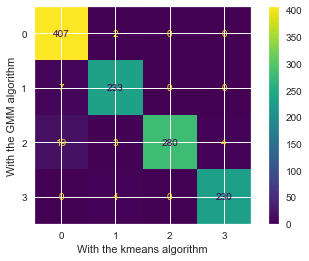

In [787]:

def matchClasses(classif1, classif2):
    cm = confusion_matrix(classif1, classif2)
    K = cm.shape[0]
    a, b = np.zeros(K), np.zeros(K)
    for j in range(K):
        for i in range(K):
            if (a[j] < cm[i,j]):
                a[j] = cm[i,j]
                b[j] = i 
    a = a.astype(int)
    b = b.astype(int)
                                             
    print ("")
    print ("Classes size:", a)
    print ("Class (in the classif1 numbering):", b)
    print ("")
    
    table = cm.copy()
    for i in range(K):
        table[:,b[i]] = cm[:,i]   
        
    clusters = classif2.copy()
    n = classif2.shape[0]
    for i in range(n):
        for j in range(K):
            if (classif2[i] == j):
                clusters[i] = b[j]
    
    accuracy = accuracy_score(classif1, clusters)  # Tính toán độ chính xác
    
    return table, clusters, accuracy

cm, clusters_kmeans_sorted, accuracy = matchClasses(clusters_gmm, clusters_kmeans)

print("Accuracy:", accuracy)

# Hiển thị ma trận confusion
ConfusionMatrixDisplay(cm).plot()
plt.xlabel('With the kmeans algorithm')
plt.ylabel('With the GMM algorithm')
plt.show()



Classes size: [233 280 230 407]
Class (in the classif1 numbering): [1 2 3 0]

Accuracy between GMM and K-means : 0.9671993271656855

Classes size: [172 181 229 419]
Class (in the classif1 numbering): [3 2 0 1]

Accuracy between HAC and K-means : 0.8418839360807401

Classes size: [225 404 190 168]
Class (in the classif1 numbering): [3 0 2 1]

Accuracy between GMM and HAC : 0.8301093355761143


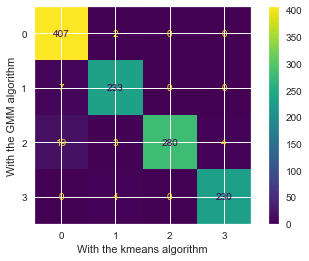

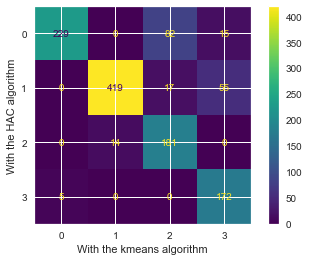

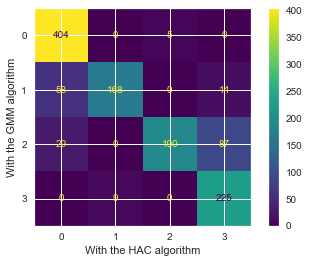

In [790]:
for k in range(1, 4):
    if k == 1:
        cm, clusters_kmeans_sorted,accuracy = matchClasses(clusters_gmm, clusters_kmeans)
        
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the kmeans algorithm')
        plt.ylabel('With the GMM algorithm')
        print("Accuracy between GMM and K-means :", accuracy)
    elif k == 2:
        cm, clusters_kmeans_sorted,accuracy = matchClasses(clusters_hac, clusters_kmeans)
        print("Accuracy between HAC and K-means :", accuracy)       
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the kmeans algorithm')
        plt.ylabel('With the HAC algorithm')

    else:
        cm, clusters_kmeans_sorted,accuracy = matchClasses(clusters_gmm, clusters_hac)
        print("Accuracy between GMM and HAC :", accuracy)
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the HAC algorithm')
        plt.ylabel('With the GMM algorithm')

plt.show()


Similarly, from the confusion matrix, we also see the same thing when the accuracy between GMM and Kmeans is similar, while HAC is different from the other two methods.

### Comparison between methods on original dataset

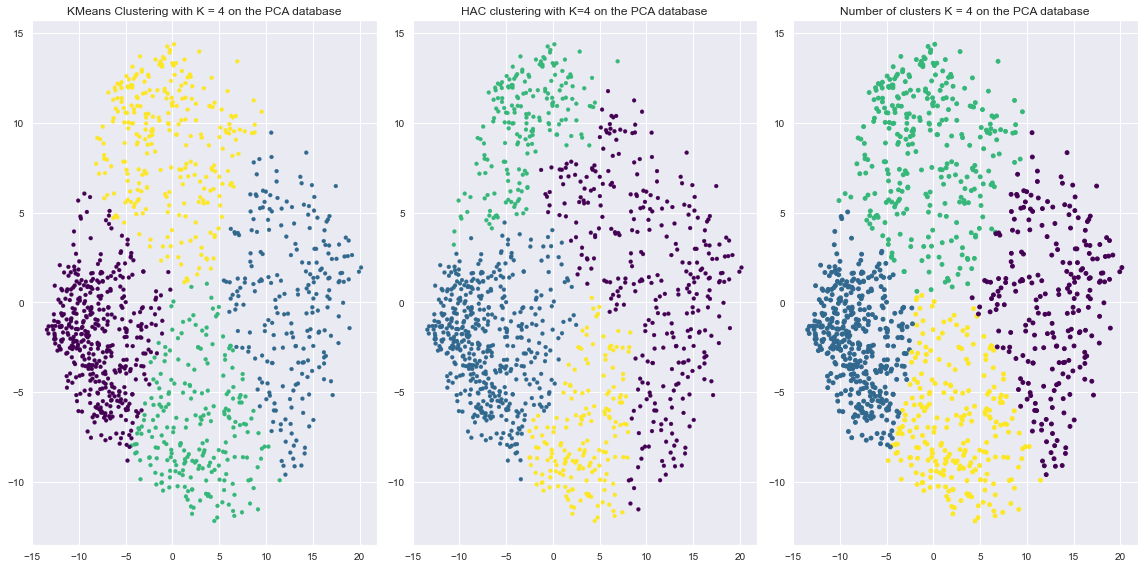

In [799]:
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_results[str(4)], s=15, cmap='viridis')
plt.title(f'KMeans Clustering with K = {4} on the PCA database')


plt.subplot(1, 3, 2)
ac_ss = AgglomerativeClustering(n_clusters=4, compute_distances=True, linkage="ward")
clusters_ac_ss = ac_ss.fit_predict(reduced)
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters_ac_ss,s=15, cmap='viridis')
plt.title(f'HAC clustering with K={K} on the PCA database')  

plt.subplot(1, 3, 3)
gmm = GaussianMixture(n_components=4, n_init=3)
clusters_gmm = gmm.fit_predict(reduced)
plt.scatter(reduced[:,0], reduced[:,1], c=clusters_gmm, s=15, linewidths=1, cmap='viridis')
plt.title("Number of clusters K = {} on the PCA database".format(K) )

plt.tight_layout()
plt.show()

The cluster methods all produce clusters with clearly different characteristics. The clustering results of the three methods are similar and perform well. As can be seen in the dim1-dim2 plane, four clusters are clearly distinguished according to positions: to the left and right of the vertical axis (dim 2), at the top and bottom of the horizontal axis (dim 1) .

- The points to the left of the vertical axis correspond to stations with low loading, while those to the right correspond to the opposite.
- Points above the horizontal axis correspond to stations with high loading during the day and low at night, while those below correspond to the opposite. Additionally, they show high variability over time.
  
Conclusion: The first main component contains information on the loading height of the stations. The second main component contains information on variability and the period during which station loading is high or low.

In [708]:
K=4 

kmeans = KMeans(n_clusters=K)
clusters_kmeans = kmeans.fit_predict(data1)

gmm = GaussianMixture(n_components=K)
clusters_gmm = gmm.fit_predict(data1)

hac_pca = AgglomerativeClustering(n_clusters=K, linkage='ward')
clusters_hac = hac_pca.fit_predict(data1)


Classes size: [441 232 276 234]
Class (in the classif1 numbering): [3 0 1 2]


Classes size: [419 166 273 173]
Class (in the classif1 numbering): [2 3 0 1]


Classes size: [271 173 417 168]
Class (in the classif1 numbering): [1 2 3 0]



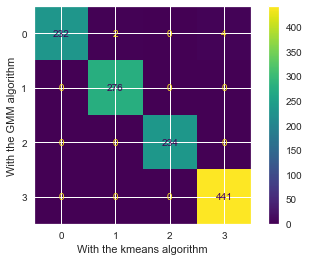

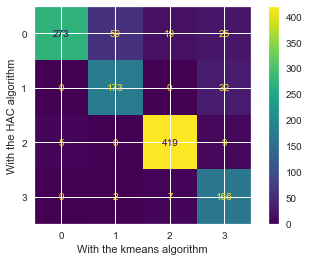

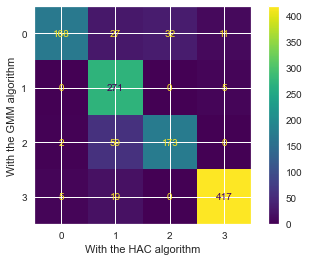

In [709]:
for k in range(1, 4):
    if k == 1:
        cm, clusters_kmeans_sorted = matchClasses(clusters_gmm, clusters_kmeans)
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the kmeans algorithm')
        plt.ylabel('With the GMM algorithm')
    elif k == 2:
        cm, clusters_kmeans_sorted = matchClasses(clusters_hac, clusters_kmeans)
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the kmeans algorithm')
        plt.ylabel('With the HAC algorithm')
    else:
        cm, clusters_kmeans_sorted = matchClasses(clusters_gmm, clusters_hac)
        ConfusionMatrixDisplay(cm).plot()
        plt.xlabel('With the HAC algorithm')
        plt.ylabel('With the GMM algorithm')

plt.show()
